# Model Development

### Steps
1. Determine the best features and models to use
2. Build Pre-Process Transformation
3. Build Pipeline
4. Grid Search and Train model
5. Serialize Model

In [2]:
#Basic Imports
#import numpy as np
import pandas as pd
import matplotlib as plt
import seaborn as sb

#Data Learning Models
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

#Data Infrastructure Pieces
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.metrics import confusion_matrix
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.externals import joblib


In [4]:
#Import the data
df = pd.read_csv('HR_comma_sep.csv')

## 1. Determine the Best Features and Models to Use

In [5]:
df.head()

,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,left,promotion_last_5years,sales,salary
0,0.38,0.53,2,157,3,0,1,0,sales,low
1,0.80,0.86,5,262,6,0,1,0,sales,medium
2,0.11,0.88,7,272,4,0,1,0,sales,medium
3,0.72,0.87,5,223,5,0,1,0,sales,low
4,0.37,0.52,2,159,3,0,1,0,sales,low


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14999 entries, 0 to 14998
Data columns (total 10 columns):
satisfaction_level       14999 non-null float64
last_evaluation          14999 non-null float64
number_project           14999 non-null int64
average_montly_hours     14999 non-null int64
time_spend_company       14999 non-null int64
Work_accident            14999 non-null int64
left                     14999 non-null int64
promotion_last_5years    14999 non-null int64
sales                    14999 non-null object
salary                   14999 non-null object
dtypes: float64(2), int64(6), object(2)
memory usage: 1.1+ MB


### Clean Data

#### There are 2 columns (sales and salary) that contains text data. We will handle these in two different ways.

In [8]:
df['sales'].value_counts()

sales          4140
technical      2720
support        2229
IT             1227
product_mng     902
marketing       858
RandD           787
accounting      767
hr              739
management      630
Name: sales, dtype: int64

In [9]:
df['salary'].value_counts()

low       7316
medium    6446
high      1237
Name: salary, dtype: int64

#### sales Cleanup.  I am going to create dummy variables for all of these categories.

In [10]:
cat_feats = ['sales']
data = pd.get_dummies(df, columns=cat_feats, drop_first=True)
data.head()

,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,left,promotion_last_5years,salary,sales_RandD,sales_accounting,sales_hr,sales_management,sales_marketing,sales_product_mng,sales_sales,sales_support,sales_technical
0,0.38,0.53,2,157,3,0,1,0,low,0,0,0,0,0,0,1,0,0
1,0.80,0.86,5,262,6,0,1,0,medium,0,0,0,0,0,0,1,0,0
2,0.11,0.88,7,272,4,0,1,0,medium,0,0,0,0,0,0,1,0,0
3,0.72,0.87,5,223,5,0,1,0,low,0,0,0,0,0,0,1,0,0
4,0.37,0.52,2,159,3,0,1,0,low,0,0,0,0,0,0,1,0,0


#### salary cleanup. I am going to replace text with a number.

In [11]:
salary_values = {'low':30000, 'medium':50000, 'high':100000}
data.replace({'salary':salary_values}, inplace=True)
data.head()

,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,left,promotion_last_5years,salary,sales_RandD,sales_accounting,sales_hr,sales_management,sales_marketing,sales_product_mng,sales_sales,sales_support,sales_technical
0,0.38,0.53,2,157,3,0,1,0,30000,0,0,0,0,0,0,1,0,0
1,0.80,0.86,5,262,6,0,1,0,50000,0,0,0,0,0,0,1,0,0
2,0.11,0.88,7,272,4,0,1,0,50000,0,0,0,0,0,0,1,0,0
3,0.72,0.87,5,223,5,0,1,0,30000,0,0,0,0,0,0,1,0,0
4,0.37,0.52,2,159,3,0,1,0,30000,0,0,0,0,0,0,1,0,0


In [12]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14999 entries, 0 to 14998
Data columns (total 18 columns):
satisfaction_level       14999 non-null float64
last_evaluation          14999 non-null float64
number_project           14999 non-null int64
average_montly_hours     14999 non-null int64
time_spend_company       14999 non-null int64
Work_accident            14999 non-null int64
left                     14999 non-null int64
promotion_last_5years    14999 non-null int64
salary                   14999 non-null int64
sales_RandD              14999 non-null uint8
sales_accounting         14999 non-null uint8
sales_hr                 14999 non-null uint8
sales_management         14999 non-null uint8
sales_marketing          14999 non-null uint8
sales_product_mng        14999 non-null uint8
sales_sales              14999 non-null uint8
sales_support            14999 non-null uint8
sales_technical          14999 non-null uint8
dtypes: float64(2), int64(7), uint8(9)
memory usage: 1.2 MB

### Choose Best Model

In [13]:
#Do the Train, Test split
X = data.drop('left', axis=1)
y = data['left']

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.3)

#### Logistic Model

In [14]:
logmodel = LogisticRegression()
logmodel.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [15]:
log_predictions = logmodel.predict(X_test)

In [18]:
logmodel.score(X_test, y_test)

0.75955555555555554

#### Decision Tree

In [21]:
tree_model = DecisionTreeClassifier()
tree_model.fit(X_train, y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

In [22]:
tree_predictions = tree_model.predict(X_test)

In [23]:
tree_model.score(X_test, y_test)

0.97844444444444445

#### Random Forest

In [24]:
forest_model = RandomForestClassifier()
forest_model.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [25]:
forest_predictions = forest_model.predict(X_test)

In [26]:
forest_model.score(X_test, y_test)

0.98888888888888893

I determined that the Random Forest model is the best model to use. It had the highest score. Ive also added more features to the data. Now to turn this into a pipeline to the results can be easily replicated.

## 2. Build Pre-process Transformation

Saw in the previous section that I had to perform multiple steps to get the features I wanted. Specifically I had to create dummy categories or more features, and turned the salary into a value. Instead of asking another data scientist to do these steps manually, lets turn this into a Transformation to use with a Pipeline.

In [26]:
class PreProcessing(BaseEstimator, TransformerMixin):
    
    def __init__(self):
        pass
    
    def transform(self, df):
        #Create new features
        #cat_feats = ['sales']
        #data = pd.get_dummies(df, columns=cat_feats, drop_first=True)
        
        #See if cat features matters
        data = df.drop('sales', axis=1)
        
        #Replace Salary
        salary_values = {'low':30000, 'medium':50000, 'high':100000}
        data.replace({'salary':salary_values}, inplace=True)
        
        return data.as_matrix()
    
    def fit(self, df, y=None, **fit_params):
        return self
        

## 3. Build Pipeline

In [27]:
pipe = make_pipeline(PreProcessing(),RandomForestClassifier())
pipe

Pipeline(memory=None,
     steps=[('preprocessing', PreProcessing()), ('randomforestclassifier', RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False))])

In [28]:
#Test
df_test = pd.read_csv('HR_comma_sep.csv')

#Do the Train, Test split
X = df_test.drop('left', axis=1)
y = df_test['left']

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.3)


In [29]:
pipe.fit(X_train, y_train)

Pipeline(memory=None,
     steps=[('preprocessing', PreProcessing()), ('randomforestclassifier', RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False))])

In [41]:
pipe.score(X_test, y_test)

0.98822222222222222

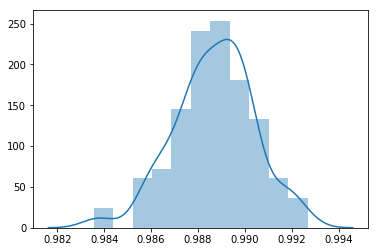

In [30]:
#There is a catch, depending on how our data was sampled, our accuracy can vary.
model_accuracies = []

for _ in range(100):
    X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.3)
    pipe.fit(X_train, y_train)
    score = pipe.score(X_test, y_test)
    model_accuracies.append(score)

    
sb.distplot(model_accuracies)

Our pipe works! Now lets add a Grid Search

## 4. Grid Search and Train

In [31]:
#Setup parameter grid
param_grid = {"randomforestclassifier__n_estimators" : [10, 20, 30],
             "randomforestclassifier__max_depth" : [None, 6, 8, 10],
             "randomforestclassifier__max_leaf_nodes": [None, 5, 10, 20], 
             "randomforestclassifier__min_impurity_split": [0.1, 0.2, 0.3]}

grid = GridSearchCV(pipe, param_grid=param_grid, cv=3)
grid

GridSearchCV(cv=3, error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('preprocessing', PreProcessing()), ('randomforestclassifier', RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impu..._jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False))]),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'randomforestclassifier__n_estimators': [10, 20, 30], 'randomforestclassifier__max_depth': [None, 6, 8, 10], 'randomforestclassifier__max_leaf_nodes': [None, 5, 10, 20], 'randomforestclassifier__min_impurity_split': [0.1, 0.2, 0.3]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

### Train the model

In [32]:
grid.fit(X_train, y_train)

/opt/conda/lib/python3.6/site-packages/sklearn/tree/tree.py:282: DeprecationWarning: The min_impurity_split parameter is deprecated and will be removed in version 0.21. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/tree/tree.py:282: DeprecationWarning: The min_impurity_split parameter is deprecated and will be removed in version 0.21. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/tree/tree.py:282: DeprecationWarning: The min_impurity_split parameter is deprecated and will be removed in version 0.21. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/tree/tree.py:282: DeprecationWarning: The min_impurity_split parameter is deprecated and will be removed in version 0.21. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)
/opt/conda/lib/python3.6/site-packages/s

/opt/conda/lib/python3.6/site-packages/sklearn/tree/tree.py:282: DeprecationWarning: The min_impurity_split parameter is deprecated and will be removed in version 0.21. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/tree/tree.py:282: DeprecationWarning: The min_impurity_split parameter is deprecated and will be removed in version 0.21. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/tree/tree.py:282: DeprecationWarning: The min_impurity_split parameter is deprecated and will be removed in version 0.21. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/tree/tree.py:282: DeprecationWarning: The min_impurity_split parameter is deprecated and will be removed in version 0.21. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)
/opt/conda/lib/python3.6/site-packages/s

/opt/conda/lib/python3.6/site-packages/sklearn/tree/tree.py:282: DeprecationWarning: The min_impurity_split parameter is deprecated and will be removed in version 0.21. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/tree/tree.py:282: DeprecationWarning: The min_impurity_split parameter is deprecated and will be removed in version 0.21. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/tree/tree.py:282: DeprecationWarning: The min_impurity_split parameter is deprecated and will be removed in version 0.21. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/tree/tree.py:282: DeprecationWarning: The min_impurity_split parameter is deprecated and will be removed in version 0.21. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)
/opt/conda/lib/python3.6/site-packages/s

/opt/conda/lib/python3.6/site-packages/sklearn/tree/tree.py:282: DeprecationWarning: The min_impurity_split parameter is deprecated and will be removed in version 0.21. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/tree/tree.py:282: DeprecationWarning: The min_impurity_split parameter is deprecated and will be removed in version 0.21. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/tree/tree.py:282: DeprecationWarning: The min_impurity_split parameter is deprecated and will be removed in version 0.21. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/tree/tree.py:282: DeprecationWarning: The min_impurity_split parameter is deprecated and will be removed in version 0.21. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)
/opt/conda/lib/python3.6/site-packages/s

/opt/conda/lib/python3.6/site-packages/sklearn/tree/tree.py:282: DeprecationWarning: The min_impurity_split parameter is deprecated and will be removed in version 0.21. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/tree/tree.py:282: DeprecationWarning: The min_impurity_split parameter is deprecated and will be removed in version 0.21. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/tree/tree.py:282: DeprecationWarning: The min_impurity_split parameter is deprecated and will be removed in version 0.21. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/tree/tree.py:282: DeprecationWarning: The min_impurity_split parameter is deprecated and will be removed in version 0.21. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)
/opt/conda/lib/python3.6/site-packages/s

/opt/conda/lib/python3.6/site-packages/sklearn/tree/tree.py:282: DeprecationWarning: The min_impurity_split parameter is deprecated and will be removed in version 0.21. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/tree/tree.py:282: DeprecationWarning: The min_impurity_split parameter is deprecated and will be removed in version 0.21. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/tree/tree.py:282: DeprecationWarning: The min_impurity_split parameter is deprecated and will be removed in version 0.21. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/tree/tree.py:282: DeprecationWarning: The min_impurity_split parameter is deprecated and will be removed in version 0.21. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)
/opt/conda/lib/python3.6/site-packages/s

/opt/conda/lib/python3.6/site-packages/sklearn/tree/tree.py:282: DeprecationWarning: The min_impurity_split parameter is deprecated and will be removed in version 0.21. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/tree/tree.py:282: DeprecationWarning: The min_impurity_split parameter is deprecated and will be removed in version 0.21. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/tree/tree.py:282: DeprecationWarning: The min_impurity_split parameter is deprecated and will be removed in version 0.21. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/tree/tree.py:282: DeprecationWarning: The min_impurity_split parameter is deprecated and will be removed in version 0.21. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)
/opt/conda/lib/python3.6/site-packages/s

/opt/conda/lib/python3.6/site-packages/sklearn/tree/tree.py:282: DeprecationWarning: The min_impurity_split parameter is deprecated and will be removed in version 0.21. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/tree/tree.py:282: DeprecationWarning: The min_impurity_split parameter is deprecated and will be removed in version 0.21. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/tree/tree.py:282: DeprecationWarning: The min_impurity_split parameter is deprecated and will be removed in version 0.21. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/tree/tree.py:282: DeprecationWarning: The min_impurity_split parameter is deprecated and will be removed in version 0.21. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)
/opt/conda/lib/python3.6/site-packages/s

/opt/conda/lib/python3.6/site-packages/sklearn/tree/tree.py:282: DeprecationWarning: The min_impurity_split parameter is deprecated and will be removed in version 0.21. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/tree/tree.py:282: DeprecationWarning: The min_impurity_split parameter is deprecated and will be removed in version 0.21. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/tree/tree.py:282: DeprecationWarning: The min_impurity_split parameter is deprecated and will be removed in version 0.21. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/tree/tree.py:282: DeprecationWarning: The min_impurity_split parameter is deprecated and will be removed in version 0.21. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)
/opt/conda/lib/python3.6/site-packages/s

/opt/conda/lib/python3.6/site-packages/sklearn/tree/tree.py:282: DeprecationWarning: The min_impurity_split parameter is deprecated and will be removed in version 0.21. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/tree/tree.py:282: DeprecationWarning: The min_impurity_split parameter is deprecated and will be removed in version 0.21. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/tree/tree.py:282: DeprecationWarning: The min_impurity_split parameter is deprecated and will be removed in version 0.21. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/tree/tree.py:282: DeprecationWarning: The min_impurity_split parameter is deprecated and will be removed in version 0.21. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)
/opt/conda/lib/python3.6/site-packages/s

/opt/conda/lib/python3.6/site-packages/sklearn/tree/tree.py:282: DeprecationWarning: The min_impurity_split parameter is deprecated and will be removed in version 0.21. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/tree/tree.py:282: DeprecationWarning: The min_impurity_split parameter is deprecated and will be removed in version 0.21. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/tree/tree.py:282: DeprecationWarning: The min_impurity_split parameter is deprecated and will be removed in version 0.21. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/tree/tree.py:282: DeprecationWarning: The min_impurity_split parameter is deprecated and will be removed in version 0.21. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)
/opt/conda/lib/python3.6/site-packages/s

/opt/conda/lib/python3.6/site-packages/sklearn/tree/tree.py:282: DeprecationWarning: The min_impurity_split parameter is deprecated and will be removed in version 0.21. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/tree/tree.py:282: DeprecationWarning: The min_impurity_split parameter is deprecated and will be removed in version 0.21. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/tree/tree.py:282: DeprecationWarning: The min_impurity_split parameter is deprecated and will be removed in version 0.21. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/tree/tree.py:282: DeprecationWarning: The min_impurity_split parameter is deprecated and will be removed in version 0.21. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)
/opt/conda/lib/python3.6/site-packages/s

/opt/conda/lib/python3.6/site-packages/sklearn/tree/tree.py:282: DeprecationWarning: The min_impurity_split parameter is deprecated and will be removed in version 0.21. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/tree/tree.py:282: DeprecationWarning: The min_impurity_split parameter is deprecated and will be removed in version 0.21. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/tree/tree.py:282: DeprecationWarning: The min_impurity_split parameter is deprecated and will be removed in version 0.21. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/tree/tree.py:282: DeprecationWarning: The min_impurity_split parameter is deprecated and will be removed in version 0.21. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)
/opt/conda/lib/python3.6/site-packages/s

/opt/conda/lib/python3.6/site-packages/sklearn/tree/tree.py:282: DeprecationWarning: The min_impurity_split parameter is deprecated and will be removed in version 0.21. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/tree/tree.py:282: DeprecationWarning: The min_impurity_split parameter is deprecated and will be removed in version 0.21. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/tree/tree.py:282: DeprecationWarning: The min_impurity_split parameter is deprecated and will be removed in version 0.21. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/tree/tree.py:282: DeprecationWarning: The min_impurity_split parameter is deprecated and will be removed in version 0.21. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)
/opt/conda/lib/python3.6/site-packages/s

/opt/conda/lib/python3.6/site-packages/sklearn/tree/tree.py:282: DeprecationWarning: The min_impurity_split parameter is deprecated and will be removed in version 0.21. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/tree/tree.py:282: DeprecationWarning: The min_impurity_split parameter is deprecated and will be removed in version 0.21. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/tree/tree.py:282: DeprecationWarning: The min_impurity_split parameter is deprecated and will be removed in version 0.21. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/tree/tree.py:282: DeprecationWarning: The min_impurity_split parameter is deprecated and will be removed in version 0.21. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)
/opt/conda/lib/python3.6/site-packages/s

/opt/conda/lib/python3.6/site-packages/sklearn/tree/tree.py:282: DeprecationWarning: The min_impurity_split parameter is deprecated and will be removed in version 0.21. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/tree/tree.py:282: DeprecationWarning: The min_impurity_split parameter is deprecated and will be removed in version 0.21. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/tree/tree.py:282: DeprecationWarning: The min_impurity_split parameter is deprecated and will be removed in version 0.21. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/tree/tree.py:282: DeprecationWarning: The min_impurity_split parameter is deprecated and will be removed in version 0.21. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)
/opt/conda/lib/python3.6/site-packages/s

/opt/conda/lib/python3.6/site-packages/sklearn/tree/tree.py:282: DeprecationWarning: The min_impurity_split parameter is deprecated and will be removed in version 0.21. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/tree/tree.py:282: DeprecationWarning: The min_impurity_split parameter is deprecated and will be removed in version 0.21. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/tree/tree.py:282: DeprecationWarning: The min_impurity_split parameter is deprecated and will be removed in version 0.21. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/tree/tree.py:282: DeprecationWarning: The min_impurity_split parameter is deprecated and will be removed in version 0.21. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)
/opt/conda/lib/python3.6/site-packages/s

/opt/conda/lib/python3.6/site-packages/sklearn/tree/tree.py:282: DeprecationWarning: The min_impurity_split parameter is deprecated and will be removed in version 0.21. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/tree/tree.py:282: DeprecationWarning: The min_impurity_split parameter is deprecated and will be removed in version 0.21. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/tree/tree.py:282: DeprecationWarning: The min_impurity_split parameter is deprecated and will be removed in version 0.21. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/tree/tree.py:282: DeprecationWarning: The min_impurity_split parameter is deprecated and will be removed in version 0.21. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)
/opt/conda/lib/python3.6/site-packages/s

/opt/conda/lib/python3.6/site-packages/sklearn/tree/tree.py:282: DeprecationWarning: The min_impurity_split parameter is deprecated and will be removed in version 0.21. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/tree/tree.py:282: DeprecationWarning: The min_impurity_split parameter is deprecated and will be removed in version 0.21. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/tree/tree.py:282: DeprecationWarning: The min_impurity_split parameter is deprecated and will be removed in version 0.21. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/tree/tree.py:282: DeprecationWarning: The min_impurity_split parameter is deprecated and will be removed in version 0.21. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)
/opt/conda/lib/python3.6/site-packages/s

/opt/conda/lib/python3.6/site-packages/sklearn/tree/tree.py:282: DeprecationWarning: The min_impurity_split parameter is deprecated and will be removed in version 0.21. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/tree/tree.py:282: DeprecationWarning: The min_impurity_split parameter is deprecated and will be removed in version 0.21. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/tree/tree.py:282: DeprecationWarning: The min_impurity_split parameter is deprecated and will be removed in version 0.21. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/tree/tree.py:282: DeprecationWarning: The min_impurity_split parameter is deprecated and will be removed in version 0.21. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)
/opt/conda/lib/python3.6/site-packages/s

/opt/conda/lib/python3.6/site-packages/sklearn/tree/tree.py:282: DeprecationWarning: The min_impurity_split parameter is deprecated and will be removed in version 0.21. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/tree/tree.py:282: DeprecationWarning: The min_impurity_split parameter is deprecated and will be removed in version 0.21. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/tree/tree.py:282: DeprecationWarning: The min_impurity_split parameter is deprecated and will be removed in version 0.21. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/tree/tree.py:282: DeprecationWarning: The min_impurity_split parameter is deprecated and will be removed in version 0.21. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)
/opt/conda/lib/python3.6/site-packages/s

/opt/conda/lib/python3.6/site-packages/sklearn/tree/tree.py:282: DeprecationWarning: The min_impurity_split parameter is deprecated and will be removed in version 0.21. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/tree/tree.py:282: DeprecationWarning: The min_impurity_split parameter is deprecated and will be removed in version 0.21. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/tree/tree.py:282: DeprecationWarning: The min_impurity_split parameter is deprecated and will be removed in version 0.21. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/tree/tree.py:282: DeprecationWarning: The min_impurity_split parameter is deprecated and will be removed in version 0.21. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)
/opt/conda/lib/python3.6/site-packages/s

/opt/conda/lib/python3.6/site-packages/sklearn/tree/tree.py:282: DeprecationWarning: The min_impurity_split parameter is deprecated and will be removed in version 0.21. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/tree/tree.py:282: DeprecationWarning: The min_impurity_split parameter is deprecated and will be removed in version 0.21. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/tree/tree.py:282: DeprecationWarning: The min_impurity_split parameter is deprecated and will be removed in version 0.21. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/tree/tree.py:282: DeprecationWarning: The min_impurity_split parameter is deprecated and will be removed in version 0.21. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)
/opt/conda/lib/python3.6/site-packages/s

/opt/conda/lib/python3.6/site-packages/sklearn/tree/tree.py:282: DeprecationWarning: The min_impurity_split parameter is deprecated and will be removed in version 0.21. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/tree/tree.py:282: DeprecationWarning: The min_impurity_split parameter is deprecated and will be removed in version 0.21. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/tree/tree.py:282: DeprecationWarning: The min_impurity_split parameter is deprecated and will be removed in version 0.21. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/tree/tree.py:282: DeprecationWarning: The min_impurity_split parameter is deprecated and will be removed in version 0.21. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)
/opt/conda/lib/python3.6/site-packages/s

/opt/conda/lib/python3.6/site-packages/sklearn/tree/tree.py:282: DeprecationWarning: The min_impurity_split parameter is deprecated and will be removed in version 0.21. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/tree/tree.py:282: DeprecationWarning: The min_impurity_split parameter is deprecated and will be removed in version 0.21. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/tree/tree.py:282: DeprecationWarning: The min_impurity_split parameter is deprecated and will be removed in version 0.21. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/tree/tree.py:282: DeprecationWarning: The min_impurity_split parameter is deprecated and will be removed in version 0.21. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)
/opt/conda/lib/python3.6/site-packages/s

/opt/conda/lib/python3.6/site-packages/sklearn/tree/tree.py:282: DeprecationWarning: The min_impurity_split parameter is deprecated and will be removed in version 0.21. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/tree/tree.py:282: DeprecationWarning: The min_impurity_split parameter is deprecated and will be removed in version 0.21. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/tree/tree.py:282: DeprecationWarning: The min_impurity_split parameter is deprecated and will be removed in version 0.21. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/tree/tree.py:282: DeprecationWarning: The min_impurity_split parameter is deprecated and will be removed in version 0.21. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)
/opt/conda/lib/python3.6/site-packages/s

/opt/conda/lib/python3.6/site-packages/sklearn/tree/tree.py:282: DeprecationWarning: The min_impurity_split parameter is deprecated and will be removed in version 0.21. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/tree/tree.py:282: DeprecationWarning: The min_impurity_split parameter is deprecated and will be removed in version 0.21. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/tree/tree.py:282: DeprecationWarning: The min_impurity_split parameter is deprecated and will be removed in version 0.21. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/tree/tree.py:282: DeprecationWarning: The min_impurity_split parameter is deprecated and will be removed in version 0.21. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)
/opt/conda/lib/python3.6/site-packages/s

/opt/conda/lib/python3.6/site-packages/sklearn/tree/tree.py:282: DeprecationWarning: The min_impurity_split parameter is deprecated and will be removed in version 0.21. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/tree/tree.py:282: DeprecationWarning: The min_impurity_split parameter is deprecated and will be removed in version 0.21. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/tree/tree.py:282: DeprecationWarning: The min_impurity_split parameter is deprecated and will be removed in version 0.21. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/tree/tree.py:282: DeprecationWarning: The min_impurity_split parameter is deprecated and will be removed in version 0.21. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)
/opt/conda/lib/python3.6/site-packages/s

/opt/conda/lib/python3.6/site-packages/sklearn/tree/tree.py:282: DeprecationWarning: The min_impurity_split parameter is deprecated and will be removed in version 0.21. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/tree/tree.py:282: DeprecationWarning: The min_impurity_split parameter is deprecated and will be removed in version 0.21. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/tree/tree.py:282: DeprecationWarning: The min_impurity_split parameter is deprecated and will be removed in version 0.21. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/tree/tree.py:282: DeprecationWarning: The min_impurity_split parameter is deprecated and will be removed in version 0.21. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)
/opt/conda/lib/python3.6/site-packages/s

/opt/conda/lib/python3.6/site-packages/sklearn/tree/tree.py:282: DeprecationWarning: The min_impurity_split parameter is deprecated and will be removed in version 0.21. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/tree/tree.py:282: DeprecationWarning: The min_impurity_split parameter is deprecated and will be removed in version 0.21. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/tree/tree.py:282: DeprecationWarning: The min_impurity_split parameter is deprecated and will be removed in version 0.21. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/tree/tree.py:282: DeprecationWarning: The min_impurity_split parameter is deprecated and will be removed in version 0.21. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)
/opt/conda/lib/python3.6/site-packages/s

/opt/conda/lib/python3.6/site-packages/sklearn/tree/tree.py:282: DeprecationWarning: The min_impurity_split parameter is deprecated and will be removed in version 0.21. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/tree/tree.py:282: DeprecationWarning: The min_impurity_split parameter is deprecated and will be removed in version 0.21. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/tree/tree.py:282: DeprecationWarning: The min_impurity_split parameter is deprecated and will be removed in version 0.21. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/tree/tree.py:282: DeprecationWarning: The min_impurity_split parameter is deprecated and will be removed in version 0.21. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)
/opt/conda/lib/python3.6/site-packages/s

/opt/conda/lib/python3.6/site-packages/sklearn/tree/tree.py:282: DeprecationWarning: The min_impurity_split parameter is deprecated and will be removed in version 0.21. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/tree/tree.py:282: DeprecationWarning: The min_impurity_split parameter is deprecated and will be removed in version 0.21. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/tree/tree.py:282: DeprecationWarning: The min_impurity_split parameter is deprecated and will be removed in version 0.21. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/tree/tree.py:282: DeprecationWarning: The min_impurity_split parameter is deprecated and will be removed in version 0.21. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)
/opt/conda/lib/python3.6/site-packages/s

/opt/conda/lib/python3.6/site-packages/sklearn/tree/tree.py:282: DeprecationWarning: The min_impurity_split parameter is deprecated and will be removed in version 0.21. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/tree/tree.py:282: DeprecationWarning: The min_impurity_split parameter is deprecated and will be removed in version 0.21. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/tree/tree.py:282: DeprecationWarning: The min_impurity_split parameter is deprecated and will be removed in version 0.21. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/tree/tree.py:282: DeprecationWarning: The min_impurity_split parameter is deprecated and will be removed in version 0.21. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)
/opt/conda/lib/python3.6/site-packages/s

/opt/conda/lib/python3.6/site-packages/sklearn/tree/tree.py:282: DeprecationWarning: The min_impurity_split parameter is deprecated and will be removed in version 0.21. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/tree/tree.py:282: DeprecationWarning: The min_impurity_split parameter is deprecated and will be removed in version 0.21. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/tree/tree.py:282: DeprecationWarning: The min_impurity_split parameter is deprecated and will be removed in version 0.21. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/tree/tree.py:282: DeprecationWarning: The min_impurity_split parameter is deprecated and will be removed in version 0.21. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)
/opt/conda/lib/python3.6/site-packages/s

/opt/conda/lib/python3.6/site-packages/sklearn/tree/tree.py:282: DeprecationWarning: The min_impurity_split parameter is deprecated and will be removed in version 0.21. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/tree/tree.py:282: DeprecationWarning: The min_impurity_split parameter is deprecated and will be removed in version 0.21. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/tree/tree.py:282: DeprecationWarning: The min_impurity_split parameter is deprecated and will be removed in version 0.21. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/tree/tree.py:282: DeprecationWarning: The min_impurity_split parameter is deprecated and will be removed in version 0.21. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)
/opt/conda/lib/python3.6/site-packages/s

/opt/conda/lib/python3.6/site-packages/sklearn/tree/tree.py:282: DeprecationWarning: The min_impurity_split parameter is deprecated and will be removed in version 0.21. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/tree/tree.py:282: DeprecationWarning: The min_impurity_split parameter is deprecated and will be removed in version 0.21. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/tree/tree.py:282: DeprecationWarning: The min_impurity_split parameter is deprecated and will be removed in version 0.21. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/tree/tree.py:282: DeprecationWarning: The min_impurity_split parameter is deprecated and will be removed in version 0.21. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)
/opt/conda/lib/python3.6/site-packages/s

/opt/conda/lib/python3.6/site-packages/sklearn/tree/tree.py:282: DeprecationWarning: The min_impurity_split parameter is deprecated and will be removed in version 0.21. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/tree/tree.py:282: DeprecationWarning: The min_impurity_split parameter is deprecated and will be removed in version 0.21. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/tree/tree.py:282: DeprecationWarning: The min_impurity_split parameter is deprecated and will be removed in version 0.21. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/tree/tree.py:282: DeprecationWarning: The min_impurity_split parameter is deprecated and will be removed in version 0.21. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)
/opt/conda/lib/python3.6/site-packages/s

/opt/conda/lib/python3.6/site-packages/sklearn/tree/tree.py:282: DeprecationWarning: The min_impurity_split parameter is deprecated and will be removed in version 0.21. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/tree/tree.py:282: DeprecationWarning: The min_impurity_split parameter is deprecated and will be removed in version 0.21. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/tree/tree.py:282: DeprecationWarning: The min_impurity_split parameter is deprecated and will be removed in version 0.21. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/tree/tree.py:282: DeprecationWarning: The min_impurity_split parameter is deprecated and will be removed in version 0.21. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)
/opt/conda/lib/python3.6/site-packages/s

/opt/conda/lib/python3.6/site-packages/sklearn/tree/tree.py:282: DeprecationWarning: The min_impurity_split parameter is deprecated and will be removed in version 0.21. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/tree/tree.py:282: DeprecationWarning: The min_impurity_split parameter is deprecated and will be removed in version 0.21. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/tree/tree.py:282: DeprecationWarning: The min_impurity_split parameter is deprecated and will be removed in version 0.21. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/tree/tree.py:282: DeprecationWarning: The min_impurity_split parameter is deprecated and will be removed in version 0.21. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)
/opt/conda/lib/python3.6/site-packages/s

/opt/conda/lib/python3.6/site-packages/sklearn/tree/tree.py:282: DeprecationWarning: The min_impurity_split parameter is deprecated and will be removed in version 0.21. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/tree/tree.py:282: DeprecationWarning: The min_impurity_split parameter is deprecated and will be removed in version 0.21. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/tree/tree.py:282: DeprecationWarning: The min_impurity_split parameter is deprecated and will be removed in version 0.21. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/tree/tree.py:282: DeprecationWarning: The min_impurity_split parameter is deprecated and will be removed in version 0.21. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)
/opt/conda/lib/python3.6/site-packages/s

/opt/conda/lib/python3.6/site-packages/sklearn/tree/tree.py:282: DeprecationWarning: The min_impurity_split parameter is deprecated and will be removed in version 0.21. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/tree/tree.py:282: DeprecationWarning: The min_impurity_split parameter is deprecated and will be removed in version 0.21. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/tree/tree.py:282: DeprecationWarning: The min_impurity_split parameter is deprecated and will be removed in version 0.21. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/tree/tree.py:282: DeprecationWarning: The min_impurity_split parameter is deprecated and will be removed in version 0.21. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)
/opt/conda/lib/python3.6/site-packages/s

/opt/conda/lib/python3.6/site-packages/sklearn/tree/tree.py:282: DeprecationWarning: The min_impurity_split parameter is deprecated and will be removed in version 0.21. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/tree/tree.py:282: DeprecationWarning: The min_impurity_split parameter is deprecated and will be removed in version 0.21. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/tree/tree.py:282: DeprecationWarning: The min_impurity_split parameter is deprecated and will be removed in version 0.21. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/tree/tree.py:282: DeprecationWarning: The min_impurity_split parameter is deprecated and will be removed in version 0.21. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)
/opt/conda/lib/python3.6/site-packages/s

/opt/conda/lib/python3.6/site-packages/sklearn/tree/tree.py:282: DeprecationWarning: The min_impurity_split parameter is deprecated and will be removed in version 0.21. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/tree/tree.py:282: DeprecationWarning: The min_impurity_split parameter is deprecated and will be removed in version 0.21. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/tree/tree.py:282: DeprecationWarning: The min_impurity_split parameter is deprecated and will be removed in version 0.21. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/tree/tree.py:282: DeprecationWarning: The min_impurity_split parameter is deprecated and will be removed in version 0.21. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)
/opt/conda/lib/python3.6/site-packages/s

/opt/conda/lib/python3.6/site-packages/sklearn/tree/tree.py:282: DeprecationWarning: The min_impurity_split parameter is deprecated and will be removed in version 0.21. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/tree/tree.py:282: DeprecationWarning: The min_impurity_split parameter is deprecated and will be removed in version 0.21. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/tree/tree.py:282: DeprecationWarning: The min_impurity_split parameter is deprecated and will be removed in version 0.21. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/tree/tree.py:282: DeprecationWarning: The min_impurity_split parameter is deprecated and will be removed in version 0.21. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)
/opt/conda/lib/python3.6/site-packages/s

/opt/conda/lib/python3.6/site-packages/sklearn/tree/tree.py:282: DeprecationWarning: The min_impurity_split parameter is deprecated and will be removed in version 0.21. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/tree/tree.py:282: DeprecationWarning: The min_impurity_split parameter is deprecated and will be removed in version 0.21. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/tree/tree.py:282: DeprecationWarning: The min_impurity_split parameter is deprecated and will be removed in version 0.21. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/tree/tree.py:282: DeprecationWarning: The min_impurity_split parameter is deprecated and will be removed in version 0.21. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)
/opt/conda/lib/python3.6/site-packages/s

/opt/conda/lib/python3.6/site-packages/sklearn/tree/tree.py:282: DeprecationWarning: The min_impurity_split parameter is deprecated and will be removed in version 0.21. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/tree/tree.py:282: DeprecationWarning: The min_impurity_split parameter is deprecated and will be removed in version 0.21. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/tree/tree.py:282: DeprecationWarning: The min_impurity_split parameter is deprecated and will be removed in version 0.21. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/tree/tree.py:282: DeprecationWarning: The min_impurity_split parameter is deprecated and will be removed in version 0.21. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)
/opt/conda/lib/python3.6/site-packages/s

/opt/conda/lib/python3.6/site-packages/sklearn/tree/tree.py:282: DeprecationWarning: The min_impurity_split parameter is deprecated and will be removed in version 0.21. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/tree/tree.py:282: DeprecationWarning: The min_impurity_split parameter is deprecated and will be removed in version 0.21. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/tree/tree.py:282: DeprecationWarning: The min_impurity_split parameter is deprecated and will be removed in version 0.21. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/tree/tree.py:282: DeprecationWarning: The min_impurity_split parameter is deprecated and will be removed in version 0.21. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)
/opt/conda/lib/python3.6/site-packages/s

/opt/conda/lib/python3.6/site-packages/sklearn/tree/tree.py:282: DeprecationWarning: The min_impurity_split parameter is deprecated and will be removed in version 0.21. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/tree/tree.py:282: DeprecationWarning: The min_impurity_split parameter is deprecated and will be removed in version 0.21. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/tree/tree.py:282: DeprecationWarning: The min_impurity_split parameter is deprecated and will be removed in version 0.21. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/tree/tree.py:282: DeprecationWarning: The min_impurity_split parameter is deprecated and will be removed in version 0.21. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)
/opt/conda/lib/python3.6/site-packages/s

/opt/conda/lib/python3.6/site-packages/sklearn/tree/tree.py:282: DeprecationWarning: The min_impurity_split parameter is deprecated and will be removed in version 0.21. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/tree/tree.py:282: DeprecationWarning: The min_impurity_split parameter is deprecated and will be removed in version 0.21. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/tree/tree.py:282: DeprecationWarning: The min_impurity_split parameter is deprecated and will be removed in version 0.21. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/tree/tree.py:282: DeprecationWarning: The min_impurity_split parameter is deprecated and will be removed in version 0.21. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)
/opt/conda/lib/python3.6/site-packages/s

/opt/conda/lib/python3.6/site-packages/sklearn/tree/tree.py:282: DeprecationWarning: The min_impurity_split parameter is deprecated and will be removed in version 0.21. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/tree/tree.py:282: DeprecationWarning: The min_impurity_split parameter is deprecated and will be removed in version 0.21. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/tree/tree.py:282: DeprecationWarning: The min_impurity_split parameter is deprecated and will be removed in version 0.21. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/tree/tree.py:282: DeprecationWarning: The min_impurity_split parameter is deprecated and will be removed in version 0.21. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)
/opt/conda/lib/python3.6/site-packages/s

/opt/conda/lib/python3.6/site-packages/sklearn/tree/tree.py:282: DeprecationWarning: The min_impurity_split parameter is deprecated and will be removed in version 0.21. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/tree/tree.py:282: DeprecationWarning: The min_impurity_split parameter is deprecated and will be removed in version 0.21. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/tree/tree.py:282: DeprecationWarning: The min_impurity_split parameter is deprecated and will be removed in version 0.21. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/tree/tree.py:282: DeprecationWarning: The min_impurity_split parameter is deprecated and will be removed in version 0.21. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)
/opt/conda/lib/python3.6/site-packages/s

/opt/conda/lib/python3.6/site-packages/sklearn/tree/tree.py:282: DeprecationWarning: The min_impurity_split parameter is deprecated and will be removed in version 0.21. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/tree/tree.py:282: DeprecationWarning: The min_impurity_split parameter is deprecated and will be removed in version 0.21. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/tree/tree.py:282: DeprecationWarning: The min_impurity_split parameter is deprecated and will be removed in version 0.21. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/tree/tree.py:282: DeprecationWarning: The min_impurity_split parameter is deprecated and will be removed in version 0.21. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)
/opt/conda/lib/python3.6/site-packages/s

/opt/conda/lib/python3.6/site-packages/sklearn/tree/tree.py:282: DeprecationWarning: The min_impurity_split parameter is deprecated and will be removed in version 0.21. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/tree/tree.py:282: DeprecationWarning: The min_impurity_split parameter is deprecated and will be removed in version 0.21. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/tree/tree.py:282: DeprecationWarning: The min_impurity_split parameter is deprecated and will be removed in version 0.21. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/tree/tree.py:282: DeprecationWarning: The min_impurity_split parameter is deprecated and will be removed in version 0.21. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)
/opt/conda/lib/python3.6/site-packages/s

/opt/conda/lib/python3.6/site-packages/sklearn/tree/tree.py:282: DeprecationWarning: The min_impurity_split parameter is deprecated and will be removed in version 0.21. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/tree/tree.py:282: DeprecationWarning: The min_impurity_split parameter is deprecated and will be removed in version 0.21. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/tree/tree.py:282: DeprecationWarning: The min_impurity_split parameter is deprecated and will be removed in version 0.21. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/tree/tree.py:282: DeprecationWarning: The min_impurity_split parameter is deprecated and will be removed in version 0.21. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)
/opt/conda/lib/python3.6/site-packages/s

/opt/conda/lib/python3.6/site-packages/sklearn/tree/tree.py:282: DeprecationWarning: The min_impurity_split parameter is deprecated and will be removed in version 0.21. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/tree/tree.py:282: DeprecationWarning: The min_impurity_split parameter is deprecated and will be removed in version 0.21. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/tree/tree.py:282: DeprecationWarning: The min_impurity_split parameter is deprecated and will be removed in version 0.21. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/tree/tree.py:282: DeprecationWarning: The min_impurity_split parameter is deprecated and will be removed in version 0.21. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)
/opt/conda/lib/python3.6/site-packages/s

/opt/conda/lib/python3.6/site-packages/sklearn/tree/tree.py:282: DeprecationWarning: The min_impurity_split parameter is deprecated and will be removed in version 0.21. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/tree/tree.py:282: DeprecationWarning: The min_impurity_split parameter is deprecated and will be removed in version 0.21. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/tree/tree.py:282: DeprecationWarning: The min_impurity_split parameter is deprecated and will be removed in version 0.21. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/tree/tree.py:282: DeprecationWarning: The min_impurity_split parameter is deprecated and will be removed in version 0.21. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)
/opt/conda/lib/python3.6/site-packages/s

/opt/conda/lib/python3.6/site-packages/sklearn/tree/tree.py:282: DeprecationWarning: The min_impurity_split parameter is deprecated and will be removed in version 0.21. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/tree/tree.py:282: DeprecationWarning: The min_impurity_split parameter is deprecated and will be removed in version 0.21. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/tree/tree.py:282: DeprecationWarning: The min_impurity_split parameter is deprecated and will be removed in version 0.21. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/tree/tree.py:282: DeprecationWarning: The min_impurity_split parameter is deprecated and will be removed in version 0.21. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)
/opt/conda/lib/python3.6/site-packages/s

/opt/conda/lib/python3.6/site-packages/sklearn/tree/tree.py:282: DeprecationWarning: The min_impurity_split parameter is deprecated and will be removed in version 0.21. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/tree/tree.py:282: DeprecationWarning: The min_impurity_split parameter is deprecated and will be removed in version 0.21. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/tree/tree.py:282: DeprecationWarning: The min_impurity_split parameter is deprecated and will be removed in version 0.21. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/tree/tree.py:282: DeprecationWarning: The min_impurity_split parameter is deprecated and will be removed in version 0.21. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)
/opt/conda/lib/python3.6/site-packages/s

/opt/conda/lib/python3.6/site-packages/sklearn/tree/tree.py:282: DeprecationWarning: The min_impurity_split parameter is deprecated and will be removed in version 0.21. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/tree/tree.py:282: DeprecationWarning: The min_impurity_split parameter is deprecated and will be removed in version 0.21. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/tree/tree.py:282: DeprecationWarning: The min_impurity_split parameter is deprecated and will be removed in version 0.21. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/tree/tree.py:282: DeprecationWarning: The min_impurity_split parameter is deprecated and will be removed in version 0.21. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)
/opt/conda/lib/python3.6/site-packages/s

/opt/conda/lib/python3.6/site-packages/sklearn/tree/tree.py:282: DeprecationWarning: The min_impurity_split parameter is deprecated and will be removed in version 0.21. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/tree/tree.py:282: DeprecationWarning: The min_impurity_split parameter is deprecated and will be removed in version 0.21. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/tree/tree.py:282: DeprecationWarning: The min_impurity_split parameter is deprecated and will be removed in version 0.21. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/tree/tree.py:282: DeprecationWarning: The min_impurity_split parameter is deprecated and will be removed in version 0.21. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)
/opt/conda/lib/python3.6/site-packages/s

/opt/conda/lib/python3.6/site-packages/sklearn/tree/tree.py:282: DeprecationWarning: The min_impurity_split parameter is deprecated and will be removed in version 0.21. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/tree/tree.py:282: DeprecationWarning: The min_impurity_split parameter is deprecated and will be removed in version 0.21. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/tree/tree.py:282: DeprecationWarning: The min_impurity_split parameter is deprecated and will be removed in version 0.21. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/tree/tree.py:282: DeprecationWarning: The min_impurity_split parameter is deprecated and will be removed in version 0.21. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)
/opt/conda/lib/python3.6/site-packages/s

/opt/conda/lib/python3.6/site-packages/sklearn/tree/tree.py:282: DeprecationWarning: The min_impurity_split parameter is deprecated and will be removed in version 0.21. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/tree/tree.py:282: DeprecationWarning: The min_impurity_split parameter is deprecated and will be removed in version 0.21. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/tree/tree.py:282: DeprecationWarning: The min_impurity_split parameter is deprecated and will be removed in version 0.21. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/tree/tree.py:282: DeprecationWarning: The min_impurity_split parameter is deprecated and will be removed in version 0.21. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)
/opt/conda/lib/python3.6/site-packages/s

/opt/conda/lib/python3.6/site-packages/sklearn/tree/tree.py:282: DeprecationWarning: The min_impurity_split parameter is deprecated and will be removed in version 0.21. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/tree/tree.py:282: DeprecationWarning: The min_impurity_split parameter is deprecated and will be removed in version 0.21. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/tree/tree.py:282: DeprecationWarning: The min_impurity_split parameter is deprecated and will be removed in version 0.21. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/tree/tree.py:282: DeprecationWarning: The min_impurity_split parameter is deprecated and will be removed in version 0.21. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)
/opt/conda/lib/python3.6/site-packages/s

/opt/conda/lib/python3.6/site-packages/sklearn/tree/tree.py:282: DeprecationWarning: The min_impurity_split parameter is deprecated and will be removed in version 0.21. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/tree/tree.py:282: DeprecationWarning: The min_impurity_split parameter is deprecated and will be removed in version 0.21. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/tree/tree.py:282: DeprecationWarning: The min_impurity_split parameter is deprecated and will be removed in version 0.21. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/tree/tree.py:282: DeprecationWarning: The min_impurity_split parameter is deprecated and will be removed in version 0.21. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)
/opt/conda/lib/python3.6/site-packages/s

/opt/conda/lib/python3.6/site-packages/sklearn/tree/tree.py:282: DeprecationWarning: The min_impurity_split parameter is deprecated and will be removed in version 0.21. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/tree/tree.py:282: DeprecationWarning: The min_impurity_split parameter is deprecated and will be removed in version 0.21. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/tree/tree.py:282: DeprecationWarning: The min_impurity_split parameter is deprecated and will be removed in version 0.21. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/tree/tree.py:282: DeprecationWarning: The min_impurity_split parameter is deprecated and will be removed in version 0.21. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)
/opt/conda/lib/python3.6/site-packages/s

/opt/conda/lib/python3.6/site-packages/sklearn/tree/tree.py:282: DeprecationWarning: The min_impurity_split parameter is deprecated and will be removed in version 0.21. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/tree/tree.py:282: DeprecationWarning: The min_impurity_split parameter is deprecated and will be removed in version 0.21. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/tree/tree.py:282: DeprecationWarning: The min_impurity_split parameter is deprecated and will be removed in version 0.21. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/tree/tree.py:282: DeprecationWarning: The min_impurity_split parameter is deprecated and will be removed in version 0.21. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)
/opt/conda/lib/python3.6/site-packages/s

/opt/conda/lib/python3.6/site-packages/sklearn/tree/tree.py:282: DeprecationWarning: The min_impurity_split parameter is deprecated and will be removed in version 0.21. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/tree/tree.py:282: DeprecationWarning: The min_impurity_split parameter is deprecated and will be removed in version 0.21. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/tree/tree.py:282: DeprecationWarning: The min_impurity_split parameter is deprecated and will be removed in version 0.21. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/tree/tree.py:282: DeprecationWarning: The min_impurity_split parameter is deprecated and will be removed in version 0.21. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)
/opt/conda/lib/python3.6/site-packages/s

/opt/conda/lib/python3.6/site-packages/sklearn/tree/tree.py:282: DeprecationWarning: The min_impurity_split parameter is deprecated and will be removed in version 0.21. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/tree/tree.py:282: DeprecationWarning: The min_impurity_split parameter is deprecated and will be removed in version 0.21. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/tree/tree.py:282: DeprecationWarning: The min_impurity_split parameter is deprecated and will be removed in version 0.21. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/tree/tree.py:282: DeprecationWarning: The min_impurity_split parameter is deprecated and will be removed in version 0.21. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)
/opt/conda/lib/python3.6/site-packages/s

/opt/conda/lib/python3.6/site-packages/sklearn/tree/tree.py:282: DeprecationWarning: The min_impurity_split parameter is deprecated and will be removed in version 0.21. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/tree/tree.py:282: DeprecationWarning: The min_impurity_split parameter is deprecated and will be removed in version 0.21. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/tree/tree.py:282: DeprecationWarning: The min_impurity_split parameter is deprecated and will be removed in version 0.21. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/tree/tree.py:282: DeprecationWarning: The min_impurity_split parameter is deprecated and will be removed in version 0.21. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)
/opt/conda/lib/python3.6/site-packages/s

/opt/conda/lib/python3.6/site-packages/sklearn/tree/tree.py:282: DeprecationWarning: The min_impurity_split parameter is deprecated and will be removed in version 0.21. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/tree/tree.py:282: DeprecationWarning: The min_impurity_split parameter is deprecated and will be removed in version 0.21. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/tree/tree.py:282: DeprecationWarning: The min_impurity_split parameter is deprecated and will be removed in version 0.21. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/tree/tree.py:282: DeprecationWarning: The min_impurity_split parameter is deprecated and will be removed in version 0.21. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)
/opt/conda/lib/python3.6/site-packages/s

/opt/conda/lib/python3.6/site-packages/sklearn/tree/tree.py:282: DeprecationWarning: The min_impurity_split parameter is deprecated and will be removed in version 0.21. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/tree/tree.py:282: DeprecationWarning: The min_impurity_split parameter is deprecated and will be removed in version 0.21. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/tree/tree.py:282: DeprecationWarning: The min_impurity_split parameter is deprecated and will be removed in version 0.21. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/tree/tree.py:282: DeprecationWarning: The min_impurity_split parameter is deprecated and will be removed in version 0.21. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)
/opt/conda/lib/python3.6/site-packages/s

/opt/conda/lib/python3.6/site-packages/sklearn/tree/tree.py:282: DeprecationWarning: The min_impurity_split parameter is deprecated and will be removed in version 0.21. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/tree/tree.py:282: DeprecationWarning: The min_impurity_split parameter is deprecated and will be removed in version 0.21. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/tree/tree.py:282: DeprecationWarning: The min_impurity_split parameter is deprecated and will be removed in version 0.21. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/tree/tree.py:282: DeprecationWarning: The min_impurity_split parameter is deprecated and will be removed in version 0.21. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)
/opt/conda/lib/python3.6/site-packages/s

/opt/conda/lib/python3.6/site-packages/sklearn/tree/tree.py:282: DeprecationWarning: The min_impurity_split parameter is deprecated and will be removed in version 0.21. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/tree/tree.py:282: DeprecationWarning: The min_impurity_split parameter is deprecated and will be removed in version 0.21. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/tree/tree.py:282: DeprecationWarning: The min_impurity_split parameter is deprecated and will be removed in version 0.21. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/tree/tree.py:282: DeprecationWarning: The min_impurity_split parameter is deprecated and will be removed in version 0.21. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)
/opt/conda/lib/python3.6/site-packages/s

/opt/conda/lib/python3.6/site-packages/sklearn/tree/tree.py:282: DeprecationWarning: The min_impurity_split parameter is deprecated and will be removed in version 0.21. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/tree/tree.py:282: DeprecationWarning: The min_impurity_split parameter is deprecated and will be removed in version 0.21. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/tree/tree.py:282: DeprecationWarning: The min_impurity_split parameter is deprecated and will be removed in version 0.21. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/tree/tree.py:282: DeprecationWarning: The min_impurity_split parameter is deprecated and will be removed in version 0.21. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)
/opt/conda/lib/python3.6/site-packages/s

/opt/conda/lib/python3.6/site-packages/sklearn/tree/tree.py:282: DeprecationWarning: The min_impurity_split parameter is deprecated and will be removed in version 0.21. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/tree/tree.py:282: DeprecationWarning: The min_impurity_split parameter is deprecated and will be removed in version 0.21. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/tree/tree.py:282: DeprecationWarning: The min_impurity_split parameter is deprecated and will be removed in version 0.21. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/tree/tree.py:282: DeprecationWarning: The min_impurity_split parameter is deprecated and will be removed in version 0.21. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)
/opt/conda/lib/python3.6/site-packages/s

/opt/conda/lib/python3.6/site-packages/sklearn/tree/tree.py:282: DeprecationWarning: The min_impurity_split parameter is deprecated and will be removed in version 0.21. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/tree/tree.py:282: DeprecationWarning: The min_impurity_split parameter is deprecated and will be removed in version 0.21. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/tree/tree.py:282: DeprecationWarning: The min_impurity_split parameter is deprecated and will be removed in version 0.21. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/tree/tree.py:282: DeprecationWarning: The min_impurity_split parameter is deprecated and will be removed in version 0.21. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)
/opt/conda/lib/python3.6/site-packages/s

/opt/conda/lib/python3.6/site-packages/sklearn/tree/tree.py:282: DeprecationWarning: The min_impurity_split parameter is deprecated and will be removed in version 0.21. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/tree/tree.py:282: DeprecationWarning: The min_impurity_split parameter is deprecated and will be removed in version 0.21. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/tree/tree.py:282: DeprecationWarning: The min_impurity_split parameter is deprecated and will be removed in version 0.21. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/tree/tree.py:282: DeprecationWarning: The min_impurity_split parameter is deprecated and will be removed in version 0.21. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)
/opt/conda/lib/python3.6/site-packages/s

/opt/conda/lib/python3.6/site-packages/sklearn/tree/tree.py:282: DeprecationWarning: The min_impurity_split parameter is deprecated and will be removed in version 0.21. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/tree/tree.py:282: DeprecationWarning: The min_impurity_split parameter is deprecated and will be removed in version 0.21. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/tree/tree.py:282: DeprecationWarning: The min_impurity_split parameter is deprecated and will be removed in version 0.21. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/tree/tree.py:282: DeprecationWarning: The min_impurity_split parameter is deprecated and will be removed in version 0.21. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)
/opt/conda/lib/python3.6/site-packages/s

/opt/conda/lib/python3.6/site-packages/sklearn/tree/tree.py:282: DeprecationWarning: The min_impurity_split parameter is deprecated and will be removed in version 0.21. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/tree/tree.py:282: DeprecationWarning: The min_impurity_split parameter is deprecated and will be removed in version 0.21. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/tree/tree.py:282: DeprecationWarning: The min_impurity_split parameter is deprecated and will be removed in version 0.21. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/tree/tree.py:282: DeprecationWarning: The min_impurity_split parameter is deprecated and will be removed in version 0.21. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)
/opt/conda/lib/python3.6/site-packages/s

/opt/conda/lib/python3.6/site-packages/sklearn/tree/tree.py:282: DeprecationWarning: The min_impurity_split parameter is deprecated and will be removed in version 0.21. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/tree/tree.py:282: DeprecationWarning: The min_impurity_split parameter is deprecated and will be removed in version 0.21. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/tree/tree.py:282: DeprecationWarning: The min_impurity_split parameter is deprecated and will be removed in version 0.21. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/tree/tree.py:282: DeprecationWarning: The min_impurity_split parameter is deprecated and will be removed in version 0.21. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)
/opt/conda/lib/python3.6/site-packages/s

/opt/conda/lib/python3.6/site-packages/sklearn/tree/tree.py:282: DeprecationWarning: The min_impurity_split parameter is deprecated and will be removed in version 0.21. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/tree/tree.py:282: DeprecationWarning: The min_impurity_split parameter is deprecated and will be removed in version 0.21. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/tree/tree.py:282: DeprecationWarning: The min_impurity_split parameter is deprecated and will be removed in version 0.21. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/tree/tree.py:282: DeprecationWarning: The min_impurity_split parameter is deprecated and will be removed in version 0.21. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)
/opt/conda/lib/python3.6/site-packages/s

/opt/conda/lib/python3.6/site-packages/sklearn/tree/tree.py:282: DeprecationWarning: The min_impurity_split parameter is deprecated and will be removed in version 0.21. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/tree/tree.py:282: DeprecationWarning: The min_impurity_split parameter is deprecated and will be removed in version 0.21. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/tree/tree.py:282: DeprecationWarning: The min_impurity_split parameter is deprecated and will be removed in version 0.21. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/tree/tree.py:282: DeprecationWarning: The min_impurity_split parameter is deprecated and will be removed in version 0.21. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)
/opt/conda/lib/python3.6/site-packages/s

/opt/conda/lib/python3.6/site-packages/sklearn/tree/tree.py:282: DeprecationWarning: The min_impurity_split parameter is deprecated and will be removed in version 0.21. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/tree/tree.py:282: DeprecationWarning: The min_impurity_split parameter is deprecated and will be removed in version 0.21. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/tree/tree.py:282: DeprecationWarning: The min_impurity_split parameter is deprecated and will be removed in version 0.21. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/tree/tree.py:282: DeprecationWarning: The min_impurity_split parameter is deprecated and will be removed in version 0.21. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)
/opt/conda/lib/python3.6/site-packages/s

/opt/conda/lib/python3.6/site-packages/sklearn/tree/tree.py:282: DeprecationWarning: The min_impurity_split parameter is deprecated and will be removed in version 0.21. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/tree/tree.py:282: DeprecationWarning: The min_impurity_split parameter is deprecated and will be removed in version 0.21. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/tree/tree.py:282: DeprecationWarning: The min_impurity_split parameter is deprecated and will be removed in version 0.21. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/tree/tree.py:282: DeprecationWarning: The min_impurity_split parameter is deprecated and will be removed in version 0.21. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)
/opt/conda/lib/python3.6/site-packages/s

/opt/conda/lib/python3.6/site-packages/sklearn/tree/tree.py:282: DeprecationWarning: The min_impurity_split parameter is deprecated and will be removed in version 0.21. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/tree/tree.py:282: DeprecationWarning: The min_impurity_split parameter is deprecated and will be removed in version 0.21. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/tree/tree.py:282: DeprecationWarning: The min_impurity_split parameter is deprecated and will be removed in version 0.21. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/tree/tree.py:282: DeprecationWarning: The min_impurity_split parameter is deprecated and will be removed in version 0.21. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)
/opt/conda/lib/python3.6/site-packages/s

/opt/conda/lib/python3.6/site-packages/sklearn/tree/tree.py:282: DeprecationWarning: The min_impurity_split parameter is deprecated and will be removed in version 0.21. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/tree/tree.py:282: DeprecationWarning: The min_impurity_split parameter is deprecated and will be removed in version 0.21. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/tree/tree.py:282: DeprecationWarning: The min_impurity_split parameter is deprecated and will be removed in version 0.21. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/tree/tree.py:282: DeprecationWarning: The min_impurity_split parameter is deprecated and will be removed in version 0.21. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)
/opt/conda/lib/python3.6/site-packages/s

/opt/conda/lib/python3.6/site-packages/sklearn/tree/tree.py:282: DeprecationWarning: The min_impurity_split parameter is deprecated and will be removed in version 0.21. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/tree/tree.py:282: DeprecationWarning: The min_impurity_split parameter is deprecated and will be removed in version 0.21. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/tree/tree.py:282: DeprecationWarning: The min_impurity_split parameter is deprecated and will be removed in version 0.21. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/tree/tree.py:282: DeprecationWarning: The min_impurity_split parameter is deprecated and will be removed in version 0.21. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)
/opt/conda/lib/python3.6/site-packages/s

/opt/conda/lib/python3.6/site-packages/sklearn/tree/tree.py:282: DeprecationWarning: The min_impurity_split parameter is deprecated and will be removed in version 0.21. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/tree/tree.py:282: DeprecationWarning: The min_impurity_split parameter is deprecated and will be removed in version 0.21. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/tree/tree.py:282: DeprecationWarning: The min_impurity_split parameter is deprecated and will be removed in version 0.21. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/tree/tree.py:282: DeprecationWarning: The min_impurity_split parameter is deprecated and will be removed in version 0.21. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)
/opt/conda/lib/python3.6/site-packages/s

/opt/conda/lib/python3.6/site-packages/sklearn/tree/tree.py:282: DeprecationWarning: The min_impurity_split parameter is deprecated and will be removed in version 0.21. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/tree/tree.py:282: DeprecationWarning: The min_impurity_split parameter is deprecated and will be removed in version 0.21. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/tree/tree.py:282: DeprecationWarning: The min_impurity_split parameter is deprecated and will be removed in version 0.21. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/tree/tree.py:282: DeprecationWarning: The min_impurity_split parameter is deprecated and will be removed in version 0.21. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)
/opt/conda/lib/python3.6/site-packages/s

/opt/conda/lib/python3.6/site-packages/sklearn/tree/tree.py:282: DeprecationWarning: The min_impurity_split parameter is deprecated and will be removed in version 0.21. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/tree/tree.py:282: DeprecationWarning: The min_impurity_split parameter is deprecated and will be removed in version 0.21. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/tree/tree.py:282: DeprecationWarning: The min_impurity_split parameter is deprecated and will be removed in version 0.21. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/tree/tree.py:282: DeprecationWarning: The min_impurity_split parameter is deprecated and will be removed in version 0.21. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)
/opt/conda/lib/python3.6/site-packages/s

/opt/conda/lib/python3.6/site-packages/sklearn/tree/tree.py:282: DeprecationWarning: The min_impurity_split parameter is deprecated and will be removed in version 0.21. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/tree/tree.py:282: DeprecationWarning: The min_impurity_split parameter is deprecated and will be removed in version 0.21. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/tree/tree.py:282: DeprecationWarning: The min_impurity_split parameter is deprecated and will be removed in version 0.21. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/tree/tree.py:282: DeprecationWarning: The min_impurity_split parameter is deprecated and will be removed in version 0.21. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)
/opt/conda/lib/python3.6/site-packages/s

/opt/conda/lib/python3.6/site-packages/sklearn/tree/tree.py:282: DeprecationWarning: The min_impurity_split parameter is deprecated and will be removed in version 0.21. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/tree/tree.py:282: DeprecationWarning: The min_impurity_split parameter is deprecated and will be removed in version 0.21. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/tree/tree.py:282: DeprecationWarning: The min_impurity_split parameter is deprecated and will be removed in version 0.21. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/tree/tree.py:282: DeprecationWarning: The min_impurity_split parameter is deprecated and will be removed in version 0.21. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)
/opt/conda/lib/python3.6/site-packages/s

/opt/conda/lib/python3.6/site-packages/sklearn/tree/tree.py:282: DeprecationWarning: The min_impurity_split parameter is deprecated and will be removed in version 0.21. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/tree/tree.py:282: DeprecationWarning: The min_impurity_split parameter is deprecated and will be removed in version 0.21. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/tree/tree.py:282: DeprecationWarning: The min_impurity_split parameter is deprecated and will be removed in version 0.21. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/tree/tree.py:282: DeprecationWarning: The min_impurity_split parameter is deprecated and will be removed in version 0.21. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)
/opt/conda/lib/python3.6/site-packages/s

/opt/conda/lib/python3.6/site-packages/sklearn/tree/tree.py:282: DeprecationWarning: The min_impurity_split parameter is deprecated and will be removed in version 0.21. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/tree/tree.py:282: DeprecationWarning: The min_impurity_split parameter is deprecated and will be removed in version 0.21. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/tree/tree.py:282: DeprecationWarning: The min_impurity_split parameter is deprecated and will be removed in version 0.21. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/tree/tree.py:282: DeprecationWarning: The min_impurity_split parameter is deprecated and will be removed in version 0.21. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)
/opt/conda/lib/python3.6/site-packages/s

/opt/conda/lib/python3.6/site-packages/sklearn/tree/tree.py:282: DeprecationWarning: The min_impurity_split parameter is deprecated and will be removed in version 0.21. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/tree/tree.py:282: DeprecationWarning: The min_impurity_split parameter is deprecated and will be removed in version 0.21. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/tree/tree.py:282: DeprecationWarning: The min_impurity_split parameter is deprecated and will be removed in version 0.21. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/tree/tree.py:282: DeprecationWarning: The min_impurity_split parameter is deprecated and will be removed in version 0.21. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)
/opt/conda/lib/python3.6/site-packages/s

/opt/conda/lib/python3.6/site-packages/sklearn/tree/tree.py:282: DeprecationWarning: The min_impurity_split parameter is deprecated and will be removed in version 0.21. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/tree/tree.py:282: DeprecationWarning: The min_impurity_split parameter is deprecated and will be removed in version 0.21. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/tree/tree.py:282: DeprecationWarning: The min_impurity_split parameter is deprecated and will be removed in version 0.21. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/tree/tree.py:282: DeprecationWarning: The min_impurity_split parameter is deprecated and will be removed in version 0.21. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)
/opt/conda/lib/python3.6/site-packages/s

/opt/conda/lib/python3.6/site-packages/sklearn/tree/tree.py:282: DeprecationWarning: The min_impurity_split parameter is deprecated and will be removed in version 0.21. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/tree/tree.py:282: DeprecationWarning: The min_impurity_split parameter is deprecated and will be removed in version 0.21. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/tree/tree.py:282: DeprecationWarning: The min_impurity_split parameter is deprecated and will be removed in version 0.21. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/tree/tree.py:282: DeprecationWarning: The min_impurity_split parameter is deprecated and will be removed in version 0.21. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)
/opt/conda/lib/python3.6/site-packages/s

/opt/conda/lib/python3.6/site-packages/sklearn/tree/tree.py:282: DeprecationWarning: The min_impurity_split parameter is deprecated and will be removed in version 0.21. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/tree/tree.py:282: DeprecationWarning: The min_impurity_split parameter is deprecated and will be removed in version 0.21. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/tree/tree.py:282: DeprecationWarning: The min_impurity_split parameter is deprecated and will be removed in version 0.21. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/tree/tree.py:282: DeprecationWarning: The min_impurity_split parameter is deprecated and will be removed in version 0.21. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)
/opt/conda/lib/python3.6/site-packages/s

/opt/conda/lib/python3.6/site-packages/sklearn/tree/tree.py:282: DeprecationWarning: The min_impurity_split parameter is deprecated and will be removed in version 0.21. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/tree/tree.py:282: DeprecationWarning: The min_impurity_split parameter is deprecated and will be removed in version 0.21. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/tree/tree.py:282: DeprecationWarning: The min_impurity_split parameter is deprecated and will be removed in version 0.21. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/tree/tree.py:282: DeprecationWarning: The min_impurity_split parameter is deprecated and will be removed in version 0.21. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)
/opt/conda/lib/python3.6/site-packages/s

/opt/conda/lib/python3.6/site-packages/sklearn/tree/tree.py:282: DeprecationWarning: The min_impurity_split parameter is deprecated and will be removed in version 0.21. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/tree/tree.py:282: DeprecationWarning: The min_impurity_split parameter is deprecated and will be removed in version 0.21. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/tree/tree.py:282: DeprecationWarning: The min_impurity_split parameter is deprecated and will be removed in version 0.21. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/tree/tree.py:282: DeprecationWarning: The min_impurity_split parameter is deprecated and will be removed in version 0.21. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)
/opt/conda/lib/python3.6/site-packages/s

/opt/conda/lib/python3.6/site-packages/sklearn/tree/tree.py:282: DeprecationWarning: The min_impurity_split parameter is deprecated and will be removed in version 0.21. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/tree/tree.py:282: DeprecationWarning: The min_impurity_split parameter is deprecated and will be removed in version 0.21. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/tree/tree.py:282: DeprecationWarning: The min_impurity_split parameter is deprecated and will be removed in version 0.21. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/tree/tree.py:282: DeprecationWarning: The min_impurity_split parameter is deprecated and will be removed in version 0.21. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)
/opt/conda/lib/python3.6/site-packages/s

/opt/conda/lib/python3.6/site-packages/sklearn/tree/tree.py:282: DeprecationWarning: The min_impurity_split parameter is deprecated and will be removed in version 0.21. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/tree/tree.py:282: DeprecationWarning: The min_impurity_split parameter is deprecated and will be removed in version 0.21. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/tree/tree.py:282: DeprecationWarning: The min_impurity_split parameter is deprecated and will be removed in version 0.21. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/tree/tree.py:282: DeprecationWarning: The min_impurity_split parameter is deprecated and will be removed in version 0.21. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)
/opt/conda/lib/python3.6/site-packages/s

/opt/conda/lib/python3.6/site-packages/sklearn/tree/tree.py:282: DeprecationWarning: The min_impurity_split parameter is deprecated and will be removed in version 0.21. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/tree/tree.py:282: DeprecationWarning: The min_impurity_split parameter is deprecated and will be removed in version 0.21. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/tree/tree.py:282: DeprecationWarning: The min_impurity_split parameter is deprecated and will be removed in version 0.21. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/tree/tree.py:282: DeprecationWarning: The min_impurity_split parameter is deprecated and will be removed in version 0.21. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)
/opt/conda/lib/python3.6/site-packages/s

/opt/conda/lib/python3.6/site-packages/sklearn/tree/tree.py:282: DeprecationWarning: The min_impurity_split parameter is deprecated and will be removed in version 0.21. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/tree/tree.py:282: DeprecationWarning: The min_impurity_split parameter is deprecated and will be removed in version 0.21. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/tree/tree.py:282: DeprecationWarning: The min_impurity_split parameter is deprecated and will be removed in version 0.21. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/tree/tree.py:282: DeprecationWarning: The min_impurity_split parameter is deprecated and will be removed in version 0.21. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)
/opt/conda/lib/python3.6/site-packages/s

/opt/conda/lib/python3.6/site-packages/sklearn/tree/tree.py:282: DeprecationWarning: The min_impurity_split parameter is deprecated and will be removed in version 0.21. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/tree/tree.py:282: DeprecationWarning: The min_impurity_split parameter is deprecated and will be removed in version 0.21. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/tree/tree.py:282: DeprecationWarning: The min_impurity_split parameter is deprecated and will be removed in version 0.21. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/tree/tree.py:282: DeprecationWarning: The min_impurity_split parameter is deprecated and will be removed in version 0.21. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)
/opt/conda/lib/python3.6/site-packages/s

/opt/conda/lib/python3.6/site-packages/sklearn/tree/tree.py:282: DeprecationWarning: The min_impurity_split parameter is deprecated and will be removed in version 0.21. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/tree/tree.py:282: DeprecationWarning: The min_impurity_split parameter is deprecated and will be removed in version 0.21. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/tree/tree.py:282: DeprecationWarning: The min_impurity_split parameter is deprecated and will be removed in version 0.21. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/tree/tree.py:282: DeprecationWarning: The min_impurity_split parameter is deprecated and will be removed in version 0.21. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)
/opt/conda/lib/python3.6/site-packages/s

/opt/conda/lib/python3.6/site-packages/sklearn/tree/tree.py:282: DeprecationWarning: The min_impurity_split parameter is deprecated and will be removed in version 0.21. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/tree/tree.py:282: DeprecationWarning: The min_impurity_split parameter is deprecated and will be removed in version 0.21. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/tree/tree.py:282: DeprecationWarning: The min_impurity_split parameter is deprecated and will be removed in version 0.21. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/tree/tree.py:282: DeprecationWarning: The min_impurity_split parameter is deprecated and will be removed in version 0.21. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)
/opt/conda/lib/python3.6/site-packages/s

/opt/conda/lib/python3.6/site-packages/sklearn/tree/tree.py:282: DeprecationWarning: The min_impurity_split parameter is deprecated and will be removed in version 0.21. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/tree/tree.py:282: DeprecationWarning: The min_impurity_split parameter is deprecated and will be removed in version 0.21. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/tree/tree.py:282: DeprecationWarning: The min_impurity_split parameter is deprecated and will be removed in version 0.21. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/tree/tree.py:282: DeprecationWarning: The min_impurity_split parameter is deprecated and will be removed in version 0.21. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)
/opt/conda/lib/python3.6/site-packages/s

/opt/conda/lib/python3.6/site-packages/sklearn/tree/tree.py:282: DeprecationWarning: The min_impurity_split parameter is deprecated and will be removed in version 0.21. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/tree/tree.py:282: DeprecationWarning: The min_impurity_split parameter is deprecated and will be removed in version 0.21. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/tree/tree.py:282: DeprecationWarning: The min_impurity_split parameter is deprecated and will be removed in version 0.21. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/tree/tree.py:282: DeprecationWarning: The min_impurity_split parameter is deprecated and will be removed in version 0.21. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)
/opt/conda/lib/python3.6/site-packages/s

/opt/conda/lib/python3.6/site-packages/sklearn/tree/tree.py:282: DeprecationWarning: The min_impurity_split parameter is deprecated and will be removed in version 0.21. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/tree/tree.py:282: DeprecationWarning: The min_impurity_split parameter is deprecated and will be removed in version 0.21. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/tree/tree.py:282: DeprecationWarning: The min_impurity_split parameter is deprecated and will be removed in version 0.21. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/tree/tree.py:282: DeprecationWarning: The min_impurity_split parameter is deprecated and will be removed in version 0.21. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)
/opt/conda/lib/python3.6/site-packages/s

/opt/conda/lib/python3.6/site-packages/sklearn/tree/tree.py:282: DeprecationWarning: The min_impurity_split parameter is deprecated and will be removed in version 0.21. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/tree/tree.py:282: DeprecationWarning: The min_impurity_split parameter is deprecated and will be removed in version 0.21. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/tree/tree.py:282: DeprecationWarning: The min_impurity_split parameter is deprecated and will be removed in version 0.21. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/tree/tree.py:282: DeprecationWarning: The min_impurity_split parameter is deprecated and will be removed in version 0.21. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)
/opt/conda/lib/python3.6/site-packages/s

/opt/conda/lib/python3.6/site-packages/sklearn/tree/tree.py:282: DeprecationWarning: The min_impurity_split parameter is deprecated and will be removed in version 0.21. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/tree/tree.py:282: DeprecationWarning: The min_impurity_split parameter is deprecated and will be removed in version 0.21. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/tree/tree.py:282: DeprecationWarning: The min_impurity_split parameter is deprecated and will be removed in version 0.21. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/tree/tree.py:282: DeprecationWarning: The min_impurity_split parameter is deprecated and will be removed in version 0.21. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)
/opt/conda/lib/python3.6/site-packages/s

/opt/conda/lib/python3.6/site-packages/sklearn/tree/tree.py:282: DeprecationWarning: The min_impurity_split parameter is deprecated and will be removed in version 0.21. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/tree/tree.py:282: DeprecationWarning: The min_impurity_split parameter is deprecated and will be removed in version 0.21. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/tree/tree.py:282: DeprecationWarning: The min_impurity_split parameter is deprecated and will be removed in version 0.21. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/tree/tree.py:282: DeprecationWarning: The min_impurity_split parameter is deprecated and will be removed in version 0.21. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)
/opt/conda/lib/python3.6/site-packages/s

/opt/conda/lib/python3.6/site-packages/sklearn/tree/tree.py:282: DeprecationWarning: The min_impurity_split parameter is deprecated and will be removed in version 0.21. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/tree/tree.py:282: DeprecationWarning: The min_impurity_split parameter is deprecated and will be removed in version 0.21. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/tree/tree.py:282: DeprecationWarning: The min_impurity_split parameter is deprecated and will be removed in version 0.21. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/tree/tree.py:282: DeprecationWarning: The min_impurity_split parameter is deprecated and will be removed in version 0.21. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)
/opt/conda/lib/python3.6/site-packages/s

/opt/conda/lib/python3.6/site-packages/sklearn/tree/tree.py:282: DeprecationWarning: The min_impurity_split parameter is deprecated and will be removed in version 0.21. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/tree/tree.py:282: DeprecationWarning: The min_impurity_split parameter is deprecated and will be removed in version 0.21. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/tree/tree.py:282: DeprecationWarning: The min_impurity_split parameter is deprecated and will be removed in version 0.21. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/tree/tree.py:282: DeprecationWarning: The min_impurity_split parameter is deprecated and will be removed in version 0.21. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)
/opt/conda/lib/python3.6/site-packages/s

/opt/conda/lib/python3.6/site-packages/sklearn/tree/tree.py:282: DeprecationWarning: The min_impurity_split parameter is deprecated and will be removed in version 0.21. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/tree/tree.py:282: DeprecationWarning: The min_impurity_split parameter is deprecated and will be removed in version 0.21. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/tree/tree.py:282: DeprecationWarning: The min_impurity_split parameter is deprecated and will be removed in version 0.21. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/tree/tree.py:282: DeprecationWarning: The min_impurity_split parameter is deprecated and will be removed in version 0.21. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)
/opt/conda/lib/python3.6/site-packages/s

/opt/conda/lib/python3.6/site-packages/sklearn/tree/tree.py:282: DeprecationWarning: The min_impurity_split parameter is deprecated and will be removed in version 0.21. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/tree/tree.py:282: DeprecationWarning: The min_impurity_split parameter is deprecated and will be removed in version 0.21. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/tree/tree.py:282: DeprecationWarning: The min_impurity_split parameter is deprecated and will be removed in version 0.21. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/tree/tree.py:282: DeprecationWarning: The min_impurity_split parameter is deprecated and will be removed in version 0.21. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)
/opt/conda/lib/python3.6/site-packages/s

/opt/conda/lib/python3.6/site-packages/sklearn/tree/tree.py:282: DeprecationWarning: The min_impurity_split parameter is deprecated and will be removed in version 0.21. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/tree/tree.py:282: DeprecationWarning: The min_impurity_split parameter is deprecated and will be removed in version 0.21. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/tree/tree.py:282: DeprecationWarning: The min_impurity_split parameter is deprecated and will be removed in version 0.21. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/tree/tree.py:282: DeprecationWarning: The min_impurity_split parameter is deprecated and will be removed in version 0.21. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)
/opt/conda/lib/python3.6/site-packages/s

/opt/conda/lib/python3.6/site-packages/sklearn/tree/tree.py:282: DeprecationWarning: The min_impurity_split parameter is deprecated and will be removed in version 0.21. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/tree/tree.py:282: DeprecationWarning: The min_impurity_split parameter is deprecated and will be removed in version 0.21. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/tree/tree.py:282: DeprecationWarning: The min_impurity_split parameter is deprecated and will be removed in version 0.21. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/tree/tree.py:282: DeprecationWarning: The min_impurity_split parameter is deprecated and will be removed in version 0.21. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)
/opt/conda/lib/python3.6/site-packages/s

/opt/conda/lib/python3.6/site-packages/sklearn/tree/tree.py:282: DeprecationWarning: The min_impurity_split parameter is deprecated and will be removed in version 0.21. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/tree/tree.py:282: DeprecationWarning: The min_impurity_split parameter is deprecated and will be removed in version 0.21. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/tree/tree.py:282: DeprecationWarning: The min_impurity_split parameter is deprecated and will be removed in version 0.21. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/tree/tree.py:282: DeprecationWarning: The min_impurity_split parameter is deprecated and will be removed in version 0.21. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)
/opt/conda/lib/python3.6/site-packages/s

/opt/conda/lib/python3.6/site-packages/sklearn/tree/tree.py:282: DeprecationWarning: The min_impurity_split parameter is deprecated and will be removed in version 0.21. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/tree/tree.py:282: DeprecationWarning: The min_impurity_split parameter is deprecated and will be removed in version 0.21. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/tree/tree.py:282: DeprecationWarning: The min_impurity_split parameter is deprecated and will be removed in version 0.21. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/tree/tree.py:282: DeprecationWarning: The min_impurity_split parameter is deprecated and will be removed in version 0.21. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)
/opt/conda/lib/python3.6/site-packages/s

/opt/conda/lib/python3.6/site-packages/sklearn/tree/tree.py:282: DeprecationWarning: The min_impurity_split parameter is deprecated and will be removed in version 0.21. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/tree/tree.py:282: DeprecationWarning: The min_impurity_split parameter is deprecated and will be removed in version 0.21. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/tree/tree.py:282: DeprecationWarning: The min_impurity_split parameter is deprecated and will be removed in version 0.21. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/tree/tree.py:282: DeprecationWarning: The min_impurity_split parameter is deprecated and will be removed in version 0.21. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)
/opt/conda/lib/python3.6/site-packages/s

/opt/conda/lib/python3.6/site-packages/sklearn/tree/tree.py:282: DeprecationWarning: The min_impurity_split parameter is deprecated and will be removed in version 0.21. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/tree/tree.py:282: DeprecationWarning: The min_impurity_split parameter is deprecated and will be removed in version 0.21. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/tree/tree.py:282: DeprecationWarning: The min_impurity_split parameter is deprecated and will be removed in version 0.21. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/tree/tree.py:282: DeprecationWarning: The min_impurity_split parameter is deprecated and will be removed in version 0.21. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)
/opt/conda/lib/python3.6/site-packages/s

/opt/conda/lib/python3.6/site-packages/sklearn/tree/tree.py:282: DeprecationWarning: The min_impurity_split parameter is deprecated and will be removed in version 0.21. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/tree/tree.py:282: DeprecationWarning: The min_impurity_split parameter is deprecated and will be removed in version 0.21. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/tree/tree.py:282: DeprecationWarning: The min_impurity_split parameter is deprecated and will be removed in version 0.21. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/tree/tree.py:282: DeprecationWarning: The min_impurity_split parameter is deprecated and will be removed in version 0.21. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)
/opt/conda/lib/python3.6/site-packages/s

/opt/conda/lib/python3.6/site-packages/sklearn/tree/tree.py:282: DeprecationWarning: The min_impurity_split parameter is deprecated and will be removed in version 0.21. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/tree/tree.py:282: DeprecationWarning: The min_impurity_split parameter is deprecated and will be removed in version 0.21. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/tree/tree.py:282: DeprecationWarning: The min_impurity_split parameter is deprecated and will be removed in version 0.21. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/tree/tree.py:282: DeprecationWarning: The min_impurity_split parameter is deprecated and will be removed in version 0.21. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)
/opt/conda/lib/python3.6/site-packages/s

/opt/conda/lib/python3.6/site-packages/sklearn/tree/tree.py:282: DeprecationWarning: The min_impurity_split parameter is deprecated and will be removed in version 0.21. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/tree/tree.py:282: DeprecationWarning: The min_impurity_split parameter is deprecated and will be removed in version 0.21. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/tree/tree.py:282: DeprecationWarning: The min_impurity_split parameter is deprecated and will be removed in version 0.21. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/tree/tree.py:282: DeprecationWarning: The min_impurity_split parameter is deprecated and will be removed in version 0.21. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)
/opt/conda/lib/python3.6/site-packages/s

/opt/conda/lib/python3.6/site-packages/sklearn/tree/tree.py:282: DeprecationWarning: The min_impurity_split parameter is deprecated and will be removed in version 0.21. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/tree/tree.py:282: DeprecationWarning: The min_impurity_split parameter is deprecated and will be removed in version 0.21. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/tree/tree.py:282: DeprecationWarning: The min_impurity_split parameter is deprecated and will be removed in version 0.21. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/tree/tree.py:282: DeprecationWarning: The min_impurity_split parameter is deprecated and will be removed in version 0.21. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)
/opt/conda/lib/python3.6/site-packages/s

/opt/conda/lib/python3.6/site-packages/sklearn/tree/tree.py:282: DeprecationWarning: The min_impurity_split parameter is deprecated and will be removed in version 0.21. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/tree/tree.py:282: DeprecationWarning: The min_impurity_split parameter is deprecated and will be removed in version 0.21. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/tree/tree.py:282: DeprecationWarning: The min_impurity_split parameter is deprecated and will be removed in version 0.21. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/tree/tree.py:282: DeprecationWarning: The min_impurity_split parameter is deprecated and will be removed in version 0.21. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)
/opt/conda/lib/python3.6/site-packages/s

/opt/conda/lib/python3.6/site-packages/sklearn/tree/tree.py:282: DeprecationWarning: The min_impurity_split parameter is deprecated and will be removed in version 0.21. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/tree/tree.py:282: DeprecationWarning: The min_impurity_split parameter is deprecated and will be removed in version 0.21. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/tree/tree.py:282: DeprecationWarning: The min_impurity_split parameter is deprecated and will be removed in version 0.21. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/tree/tree.py:282: DeprecationWarning: The min_impurity_split parameter is deprecated and will be removed in version 0.21. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)
/opt/conda/lib/python3.6/site-packages/s

/opt/conda/lib/python3.6/site-packages/sklearn/tree/tree.py:282: DeprecationWarning: The min_impurity_split parameter is deprecated and will be removed in version 0.21. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/tree/tree.py:282: DeprecationWarning: The min_impurity_split parameter is deprecated and will be removed in version 0.21. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/tree/tree.py:282: DeprecationWarning: The min_impurity_split parameter is deprecated and will be removed in version 0.21. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/tree/tree.py:282: DeprecationWarning: The min_impurity_split parameter is deprecated and will be removed in version 0.21. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)
/opt/conda/lib/python3.6/site-packages/s

/opt/conda/lib/python3.6/site-packages/sklearn/tree/tree.py:282: DeprecationWarning: The min_impurity_split parameter is deprecated and will be removed in version 0.21. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/tree/tree.py:282: DeprecationWarning: The min_impurity_split parameter is deprecated and will be removed in version 0.21. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/tree/tree.py:282: DeprecationWarning: The min_impurity_split parameter is deprecated and will be removed in version 0.21. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/tree/tree.py:282: DeprecationWarning: The min_impurity_split parameter is deprecated and will be removed in version 0.21. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)
/opt/conda/lib/python3.6/site-packages/s

/opt/conda/lib/python3.6/site-packages/sklearn/tree/tree.py:282: DeprecationWarning: The min_impurity_split parameter is deprecated and will be removed in version 0.21. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/tree/tree.py:282: DeprecationWarning: The min_impurity_split parameter is deprecated and will be removed in version 0.21. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/tree/tree.py:282: DeprecationWarning: The min_impurity_split parameter is deprecated and will be removed in version 0.21. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/tree/tree.py:282: DeprecationWarning: The min_impurity_split parameter is deprecated and will be removed in version 0.21. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)
/opt/conda/lib/python3.6/site-packages/s

/opt/conda/lib/python3.6/site-packages/sklearn/tree/tree.py:282: DeprecationWarning: The min_impurity_split parameter is deprecated and will be removed in version 0.21. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/tree/tree.py:282: DeprecationWarning: The min_impurity_split parameter is deprecated and will be removed in version 0.21. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/tree/tree.py:282: DeprecationWarning: The min_impurity_split parameter is deprecated and will be removed in version 0.21. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/tree/tree.py:282: DeprecationWarning: The min_impurity_split parameter is deprecated and will be removed in version 0.21. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)
/opt/conda/lib/python3.6/site-packages/s

/opt/conda/lib/python3.6/site-packages/sklearn/tree/tree.py:282: DeprecationWarning: The min_impurity_split parameter is deprecated and will be removed in version 0.21. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/tree/tree.py:282: DeprecationWarning: The min_impurity_split parameter is deprecated and will be removed in version 0.21. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/tree/tree.py:282: DeprecationWarning: The min_impurity_split parameter is deprecated and will be removed in version 0.21. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/tree/tree.py:282: DeprecationWarning: The min_impurity_split parameter is deprecated and will be removed in version 0.21. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)
/opt/conda/lib/python3.6/site-packages/s

/opt/conda/lib/python3.6/site-packages/sklearn/tree/tree.py:282: DeprecationWarning: The min_impurity_split parameter is deprecated and will be removed in version 0.21. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/tree/tree.py:282: DeprecationWarning: The min_impurity_split parameter is deprecated and will be removed in version 0.21. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/tree/tree.py:282: DeprecationWarning: The min_impurity_split parameter is deprecated and will be removed in version 0.21. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/tree/tree.py:282: DeprecationWarning: The min_impurity_split parameter is deprecated and will be removed in version 0.21. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)
/opt/conda/lib/python3.6/site-packages/s

/opt/conda/lib/python3.6/site-packages/sklearn/tree/tree.py:282: DeprecationWarning: The min_impurity_split parameter is deprecated and will be removed in version 0.21. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/tree/tree.py:282: DeprecationWarning: The min_impurity_split parameter is deprecated and will be removed in version 0.21. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/tree/tree.py:282: DeprecationWarning: The min_impurity_split parameter is deprecated and will be removed in version 0.21. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/tree/tree.py:282: DeprecationWarning: The min_impurity_split parameter is deprecated and will be removed in version 0.21. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)
/opt/conda/lib/python3.6/site-packages/s

/opt/conda/lib/python3.6/site-packages/sklearn/tree/tree.py:282: DeprecationWarning: The min_impurity_split parameter is deprecated and will be removed in version 0.21. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/tree/tree.py:282: DeprecationWarning: The min_impurity_split parameter is deprecated and will be removed in version 0.21. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/tree/tree.py:282: DeprecationWarning: The min_impurity_split parameter is deprecated and will be removed in version 0.21. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/tree/tree.py:282: DeprecationWarning: The min_impurity_split parameter is deprecated and will be removed in version 0.21. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)
/opt/conda/lib/python3.6/site-packages/s

/opt/conda/lib/python3.6/site-packages/sklearn/tree/tree.py:282: DeprecationWarning: The min_impurity_split parameter is deprecated and will be removed in version 0.21. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/tree/tree.py:282: DeprecationWarning: The min_impurity_split parameter is deprecated and will be removed in version 0.21. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/tree/tree.py:282: DeprecationWarning: The min_impurity_split parameter is deprecated and will be removed in version 0.21. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/tree/tree.py:282: DeprecationWarning: The min_impurity_split parameter is deprecated and will be removed in version 0.21. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)
/opt/conda/lib/python3.6/site-packages/s

/opt/conda/lib/python3.6/site-packages/sklearn/tree/tree.py:282: DeprecationWarning: The min_impurity_split parameter is deprecated and will be removed in version 0.21. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/tree/tree.py:282: DeprecationWarning: The min_impurity_split parameter is deprecated and will be removed in version 0.21. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/tree/tree.py:282: DeprecationWarning: The min_impurity_split parameter is deprecated and will be removed in version 0.21. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/tree/tree.py:282: DeprecationWarning: The min_impurity_split parameter is deprecated and will be removed in version 0.21. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)
/opt/conda/lib/python3.6/site-packages/s

/opt/conda/lib/python3.6/site-packages/sklearn/tree/tree.py:282: DeprecationWarning: The min_impurity_split parameter is deprecated and will be removed in version 0.21. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/tree/tree.py:282: DeprecationWarning: The min_impurity_split parameter is deprecated and will be removed in version 0.21. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/tree/tree.py:282: DeprecationWarning: The min_impurity_split parameter is deprecated and will be removed in version 0.21. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/tree/tree.py:282: DeprecationWarning: The min_impurity_split parameter is deprecated and will be removed in version 0.21. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)
/opt/conda/lib/python3.6/site-packages/s

/opt/conda/lib/python3.6/site-packages/sklearn/tree/tree.py:282: DeprecationWarning: The min_impurity_split parameter is deprecated and will be removed in version 0.21. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/tree/tree.py:282: DeprecationWarning: The min_impurity_split parameter is deprecated and will be removed in version 0.21. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/tree/tree.py:282: DeprecationWarning: The min_impurity_split parameter is deprecated and will be removed in version 0.21. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/tree/tree.py:282: DeprecationWarning: The min_impurity_split parameter is deprecated and will be removed in version 0.21. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)
/opt/conda/lib/python3.6/site-packages/s

/opt/conda/lib/python3.6/site-packages/sklearn/tree/tree.py:282: DeprecationWarning: The min_impurity_split parameter is deprecated and will be removed in version 0.21. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/tree/tree.py:282: DeprecationWarning: The min_impurity_split parameter is deprecated and will be removed in version 0.21. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/tree/tree.py:282: DeprecationWarning: The min_impurity_split parameter is deprecated and will be removed in version 0.21. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/tree/tree.py:282: DeprecationWarning: The min_impurity_split parameter is deprecated and will be removed in version 0.21. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)
/opt/conda/lib/python3.6/site-packages/s

/opt/conda/lib/python3.6/site-packages/sklearn/tree/tree.py:282: DeprecationWarning: The min_impurity_split parameter is deprecated and will be removed in version 0.21. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/tree/tree.py:282: DeprecationWarning: The min_impurity_split parameter is deprecated and will be removed in version 0.21. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/tree/tree.py:282: DeprecationWarning: The min_impurity_split parameter is deprecated and will be removed in version 0.21. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/tree/tree.py:282: DeprecationWarning: The min_impurity_split parameter is deprecated and will be removed in version 0.21. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)
/opt/conda/lib/python3.6/site-packages/s

/opt/conda/lib/python3.6/site-packages/sklearn/tree/tree.py:282: DeprecationWarning: The min_impurity_split parameter is deprecated and will be removed in version 0.21. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/tree/tree.py:282: DeprecationWarning: The min_impurity_split parameter is deprecated and will be removed in version 0.21. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/tree/tree.py:282: DeprecationWarning: The min_impurity_split parameter is deprecated and will be removed in version 0.21. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/tree/tree.py:282: DeprecationWarning: The min_impurity_split parameter is deprecated and will be removed in version 0.21. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)
/opt/conda/lib/python3.6/site-packages/s

/opt/conda/lib/python3.6/site-packages/sklearn/tree/tree.py:282: DeprecationWarning: The min_impurity_split parameter is deprecated and will be removed in version 0.21. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/tree/tree.py:282: DeprecationWarning: The min_impurity_split parameter is deprecated and will be removed in version 0.21. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/tree/tree.py:282: DeprecationWarning: The min_impurity_split parameter is deprecated and will be removed in version 0.21. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/tree/tree.py:282: DeprecationWarning: The min_impurity_split parameter is deprecated and will be removed in version 0.21. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)
/opt/conda/lib/python3.6/site-packages/s

/opt/conda/lib/python3.6/site-packages/sklearn/tree/tree.py:282: DeprecationWarning: The min_impurity_split parameter is deprecated and will be removed in version 0.21. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/tree/tree.py:282: DeprecationWarning: The min_impurity_split parameter is deprecated and will be removed in version 0.21. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/tree/tree.py:282: DeprecationWarning: The min_impurity_split parameter is deprecated and will be removed in version 0.21. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/tree/tree.py:282: DeprecationWarning: The min_impurity_split parameter is deprecated and will be removed in version 0.21. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)
/opt/conda/lib/python3.6/site-packages/s

/opt/conda/lib/python3.6/site-packages/sklearn/tree/tree.py:282: DeprecationWarning: The min_impurity_split parameter is deprecated and will be removed in version 0.21. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/tree/tree.py:282: DeprecationWarning: The min_impurity_split parameter is deprecated and will be removed in version 0.21. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/tree/tree.py:282: DeprecationWarning: The min_impurity_split parameter is deprecated and will be removed in version 0.21. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/tree/tree.py:282: DeprecationWarning: The min_impurity_split parameter is deprecated and will be removed in version 0.21. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)
/opt/conda/lib/python3.6/site-packages/s

/opt/conda/lib/python3.6/site-packages/sklearn/tree/tree.py:282: DeprecationWarning: The min_impurity_split parameter is deprecated and will be removed in version 0.21. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/tree/tree.py:282: DeprecationWarning: The min_impurity_split parameter is deprecated and will be removed in version 0.21. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/tree/tree.py:282: DeprecationWarning: The min_impurity_split parameter is deprecated and will be removed in version 0.21. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/tree/tree.py:282: DeprecationWarning: The min_impurity_split parameter is deprecated and will be removed in version 0.21. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)
/opt/conda/lib/python3.6/site-packages/s

/opt/conda/lib/python3.6/site-packages/sklearn/tree/tree.py:282: DeprecationWarning: The min_impurity_split parameter is deprecated and will be removed in version 0.21. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/tree/tree.py:282: DeprecationWarning: The min_impurity_split parameter is deprecated and will be removed in version 0.21. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/tree/tree.py:282: DeprecationWarning: The min_impurity_split parameter is deprecated and will be removed in version 0.21. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/tree/tree.py:282: DeprecationWarning: The min_impurity_split parameter is deprecated and will be removed in version 0.21. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)
/opt/conda/lib/python3.6/site-packages/s

/opt/conda/lib/python3.6/site-packages/sklearn/tree/tree.py:282: DeprecationWarning: The min_impurity_split parameter is deprecated and will be removed in version 0.21. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/tree/tree.py:282: DeprecationWarning: The min_impurity_split parameter is deprecated and will be removed in version 0.21. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/tree/tree.py:282: DeprecationWarning: The min_impurity_split parameter is deprecated and will be removed in version 0.21. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/tree/tree.py:282: DeprecationWarning: The min_impurity_split parameter is deprecated and will be removed in version 0.21. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)
/opt/conda/lib/python3.6/site-packages/s

/opt/conda/lib/python3.6/site-packages/sklearn/tree/tree.py:282: DeprecationWarning: The min_impurity_split parameter is deprecated and will be removed in version 0.21. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/tree/tree.py:282: DeprecationWarning: The min_impurity_split parameter is deprecated and will be removed in version 0.21. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/tree/tree.py:282: DeprecationWarning: The min_impurity_split parameter is deprecated and will be removed in version 0.21. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/tree/tree.py:282: DeprecationWarning: The min_impurity_split parameter is deprecated and will be removed in version 0.21. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)
/opt/conda/lib/python3.6/site-packages/s

/opt/conda/lib/python3.6/site-packages/sklearn/tree/tree.py:282: DeprecationWarning: The min_impurity_split parameter is deprecated and will be removed in version 0.21. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/tree/tree.py:282: DeprecationWarning: The min_impurity_split parameter is deprecated and will be removed in version 0.21. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/tree/tree.py:282: DeprecationWarning: The min_impurity_split parameter is deprecated and will be removed in version 0.21. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/tree/tree.py:282: DeprecationWarning: The min_impurity_split parameter is deprecated and will be removed in version 0.21. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)
/opt/conda/lib/python3.6/site-packages/s

/opt/conda/lib/python3.6/site-packages/sklearn/tree/tree.py:282: DeprecationWarning: The min_impurity_split parameter is deprecated and will be removed in version 0.21. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/tree/tree.py:282: DeprecationWarning: The min_impurity_split parameter is deprecated and will be removed in version 0.21. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/tree/tree.py:282: DeprecationWarning: The min_impurity_split parameter is deprecated and will be removed in version 0.21. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/tree/tree.py:282: DeprecationWarning: The min_impurity_split parameter is deprecated and will be removed in version 0.21. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)
/opt/conda/lib/python3.6/site-packages/s

/opt/conda/lib/python3.6/site-packages/sklearn/tree/tree.py:282: DeprecationWarning: The min_impurity_split parameter is deprecated and will be removed in version 0.21. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/tree/tree.py:282: DeprecationWarning: The min_impurity_split parameter is deprecated and will be removed in version 0.21. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/tree/tree.py:282: DeprecationWarning: The min_impurity_split parameter is deprecated and will be removed in version 0.21. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/tree/tree.py:282: DeprecationWarning: The min_impurity_split parameter is deprecated and will be removed in version 0.21. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)
/opt/conda/lib/python3.6/site-packages/s

/opt/conda/lib/python3.6/site-packages/sklearn/tree/tree.py:282: DeprecationWarning: The min_impurity_split parameter is deprecated and will be removed in version 0.21. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/tree/tree.py:282: DeprecationWarning: The min_impurity_split parameter is deprecated and will be removed in version 0.21. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/tree/tree.py:282: DeprecationWarning: The min_impurity_split parameter is deprecated and will be removed in version 0.21. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/tree/tree.py:282: DeprecationWarning: The min_impurity_split parameter is deprecated and will be removed in version 0.21. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)
/opt/conda/lib/python3.6/site-packages/s

/opt/conda/lib/python3.6/site-packages/sklearn/tree/tree.py:282: DeprecationWarning: The min_impurity_split parameter is deprecated and will be removed in version 0.21. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/tree/tree.py:282: DeprecationWarning: The min_impurity_split parameter is deprecated and will be removed in version 0.21. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/tree/tree.py:282: DeprecationWarning: The min_impurity_split parameter is deprecated and will be removed in version 0.21. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/tree/tree.py:282: DeprecationWarning: The min_impurity_split parameter is deprecated and will be removed in version 0.21. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)
/opt/conda/lib/python3.6/site-packages/s

/opt/conda/lib/python3.6/site-packages/sklearn/tree/tree.py:282: DeprecationWarning: The min_impurity_split parameter is deprecated and will be removed in version 0.21. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/tree/tree.py:282: DeprecationWarning: The min_impurity_split parameter is deprecated and will be removed in version 0.21. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/tree/tree.py:282: DeprecationWarning: The min_impurity_split parameter is deprecated and will be removed in version 0.21. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/tree/tree.py:282: DeprecationWarning: The min_impurity_split parameter is deprecated and will be removed in version 0.21. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)
/opt/conda/lib/python3.6/site-packages/s

/opt/conda/lib/python3.6/site-packages/sklearn/tree/tree.py:282: DeprecationWarning: The min_impurity_split parameter is deprecated and will be removed in version 0.21. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/tree/tree.py:282: DeprecationWarning: The min_impurity_split parameter is deprecated and will be removed in version 0.21. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/tree/tree.py:282: DeprecationWarning: The min_impurity_split parameter is deprecated and will be removed in version 0.21. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/tree/tree.py:282: DeprecationWarning: The min_impurity_split parameter is deprecated and will be removed in version 0.21. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)
/opt/conda/lib/python3.6/site-packages/s

/opt/conda/lib/python3.6/site-packages/sklearn/tree/tree.py:282: DeprecationWarning: The min_impurity_split parameter is deprecated and will be removed in version 0.21. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/tree/tree.py:282: DeprecationWarning: The min_impurity_split parameter is deprecated and will be removed in version 0.21. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/tree/tree.py:282: DeprecationWarning: The min_impurity_split parameter is deprecated and will be removed in version 0.21. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/tree/tree.py:282: DeprecationWarning: The min_impurity_split parameter is deprecated and will be removed in version 0.21. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)
/opt/conda/lib/python3.6/site-packages/s

/opt/conda/lib/python3.6/site-packages/sklearn/tree/tree.py:282: DeprecationWarning: The min_impurity_split parameter is deprecated and will be removed in version 0.21. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/tree/tree.py:282: DeprecationWarning: The min_impurity_split parameter is deprecated and will be removed in version 0.21. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/tree/tree.py:282: DeprecationWarning: The min_impurity_split parameter is deprecated and will be removed in version 0.21. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/tree/tree.py:282: DeprecationWarning: The min_impurity_split parameter is deprecated and will be removed in version 0.21. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)
/opt/conda/lib/python3.6/site-packages/s

/opt/conda/lib/python3.6/site-packages/sklearn/tree/tree.py:282: DeprecationWarning: The min_impurity_split parameter is deprecated and will be removed in version 0.21. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/tree/tree.py:282: DeprecationWarning: The min_impurity_split parameter is deprecated and will be removed in version 0.21. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/tree/tree.py:282: DeprecationWarning: The min_impurity_split parameter is deprecated and will be removed in version 0.21. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/tree/tree.py:282: DeprecationWarning: The min_impurity_split parameter is deprecated and will be removed in version 0.21. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)
/opt/conda/lib/python3.6/site-packages/s

/opt/conda/lib/python3.6/site-packages/sklearn/tree/tree.py:282: DeprecationWarning: The min_impurity_split parameter is deprecated and will be removed in version 0.21. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/tree/tree.py:282: DeprecationWarning: The min_impurity_split parameter is deprecated and will be removed in version 0.21. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/tree/tree.py:282: DeprecationWarning: The min_impurity_split parameter is deprecated and will be removed in version 0.21. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/tree/tree.py:282: DeprecationWarning: The min_impurity_split parameter is deprecated and will be removed in version 0.21. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)
/opt/conda/lib/python3.6/site-packages/s

/opt/conda/lib/python3.6/site-packages/sklearn/tree/tree.py:282: DeprecationWarning: The min_impurity_split parameter is deprecated and will be removed in version 0.21. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/tree/tree.py:282: DeprecationWarning: The min_impurity_split parameter is deprecated and will be removed in version 0.21. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/tree/tree.py:282: DeprecationWarning: The min_impurity_split parameter is deprecated and will be removed in version 0.21. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/tree/tree.py:282: DeprecationWarning: The min_impurity_split parameter is deprecated and will be removed in version 0.21. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)
/opt/conda/lib/python3.6/site-packages/s

/opt/conda/lib/python3.6/site-packages/sklearn/tree/tree.py:282: DeprecationWarning: The min_impurity_split parameter is deprecated and will be removed in version 0.21. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/tree/tree.py:282: DeprecationWarning: The min_impurity_split parameter is deprecated and will be removed in version 0.21. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/tree/tree.py:282: DeprecationWarning: The min_impurity_split parameter is deprecated and will be removed in version 0.21. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/tree/tree.py:282: DeprecationWarning: The min_impurity_split parameter is deprecated and will be removed in version 0.21. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)
/opt/conda/lib/python3.6/site-packages/s

/opt/conda/lib/python3.6/site-packages/sklearn/tree/tree.py:282: DeprecationWarning: The min_impurity_split parameter is deprecated and will be removed in version 0.21. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/tree/tree.py:282: DeprecationWarning: The min_impurity_split parameter is deprecated and will be removed in version 0.21. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/tree/tree.py:282: DeprecationWarning: The min_impurity_split parameter is deprecated and will be removed in version 0.21. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/tree/tree.py:282: DeprecationWarning: The min_impurity_split parameter is deprecated and will be removed in version 0.21. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)
/opt/conda/lib/python3.6/site-packages/s

/opt/conda/lib/python3.6/site-packages/sklearn/tree/tree.py:282: DeprecationWarning: The min_impurity_split parameter is deprecated and will be removed in version 0.21. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/tree/tree.py:282: DeprecationWarning: The min_impurity_split parameter is deprecated and will be removed in version 0.21. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/tree/tree.py:282: DeprecationWarning: The min_impurity_split parameter is deprecated and will be removed in version 0.21. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/tree/tree.py:282: DeprecationWarning: The min_impurity_split parameter is deprecated and will be removed in version 0.21. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)
/opt/conda/lib/python3.6/site-packages/s

/opt/conda/lib/python3.6/site-packages/sklearn/tree/tree.py:282: DeprecationWarning: The min_impurity_split parameter is deprecated and will be removed in version 0.21. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/tree/tree.py:282: DeprecationWarning: The min_impurity_split parameter is deprecated and will be removed in version 0.21. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/tree/tree.py:282: DeprecationWarning: The min_impurity_split parameter is deprecated and will be removed in version 0.21. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/tree/tree.py:282: DeprecationWarning: The min_impurity_split parameter is deprecated and will be removed in version 0.21. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)
/opt/conda/lib/python3.6/site-packages/s

/opt/conda/lib/python3.6/site-packages/sklearn/tree/tree.py:282: DeprecationWarning: The min_impurity_split parameter is deprecated and will be removed in version 0.21. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/tree/tree.py:282: DeprecationWarning: The min_impurity_split parameter is deprecated and will be removed in version 0.21. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/tree/tree.py:282: DeprecationWarning: The min_impurity_split parameter is deprecated and will be removed in version 0.21. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/tree/tree.py:282: DeprecationWarning: The min_impurity_split parameter is deprecated and will be removed in version 0.21. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)
/opt/conda/lib/python3.6/site-packages/s

/opt/conda/lib/python3.6/site-packages/sklearn/tree/tree.py:282: DeprecationWarning: The min_impurity_split parameter is deprecated and will be removed in version 0.21. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/tree/tree.py:282: DeprecationWarning: The min_impurity_split parameter is deprecated and will be removed in version 0.21. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/tree/tree.py:282: DeprecationWarning: The min_impurity_split parameter is deprecated and will be removed in version 0.21. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/tree/tree.py:282: DeprecationWarning: The min_impurity_split parameter is deprecated and will be removed in version 0.21. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)
/opt/conda/lib/python3.6/site-packages/s

/opt/conda/lib/python3.6/site-packages/sklearn/tree/tree.py:282: DeprecationWarning: The min_impurity_split parameter is deprecated and will be removed in version 0.21. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/tree/tree.py:282: DeprecationWarning: The min_impurity_split parameter is deprecated and will be removed in version 0.21. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/tree/tree.py:282: DeprecationWarning: The min_impurity_split parameter is deprecated and will be removed in version 0.21. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/tree/tree.py:282: DeprecationWarning: The min_impurity_split parameter is deprecated and will be removed in version 0.21. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)
/opt/conda/lib/python3.6/site-packages/s

/opt/conda/lib/python3.6/site-packages/sklearn/tree/tree.py:282: DeprecationWarning: The min_impurity_split parameter is deprecated and will be removed in version 0.21. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/tree/tree.py:282: DeprecationWarning: The min_impurity_split parameter is deprecated and will be removed in version 0.21. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/tree/tree.py:282: DeprecationWarning: The min_impurity_split parameter is deprecated and will be removed in version 0.21. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/tree/tree.py:282: DeprecationWarning: The min_impurity_split parameter is deprecated and will be removed in version 0.21. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)
/opt/conda/lib/python3.6/site-packages/s

/opt/conda/lib/python3.6/site-packages/sklearn/tree/tree.py:282: DeprecationWarning: The min_impurity_split parameter is deprecated and will be removed in version 0.21. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/tree/tree.py:282: DeprecationWarning: The min_impurity_split parameter is deprecated and will be removed in version 0.21. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/tree/tree.py:282: DeprecationWarning: The min_impurity_split parameter is deprecated and will be removed in version 0.21. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/tree/tree.py:282: DeprecationWarning: The min_impurity_split parameter is deprecated and will be removed in version 0.21. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)
/opt/conda/lib/python3.6/site-packages/s

GridSearchCV(cv=3, error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('preprocessing', PreProcessing()), ('randomforestclassifier', RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impu..._jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False))]),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'randomforestclassifier__n_estimators': [10, 20, 30], 'randomforestclassifier__max_depth': [None, 6, 8, 10], 'randomforestclassifier__max_leaf_nodes': [None, 5, 10, 20], 'randomforestclassifier__min_impurity_split': [0.1, 0.2, 0.3]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [33]:
print("Best parameters: {}".format(grid.best_params_))

Best parameters: {'randomforestclassifier__max_depth': None, 'randomforestclassifier__max_leaf_nodes': None, 'randomforestclassifier__min_impurity_split': 0.1, 'randomforestclassifier__n_estimators': 10}


In [34]:
grid.score(X_test, y_test)

0.97799999999999998

In [35]:
predictions = grid.predict(X_test)

In [36]:
predictions

array([1, 0, 0, ..., 0, 0, 1])

In [37]:
predict_proba = grid.predict_proba(X_test)
predict_proba

array([[ 0.41481823,  0.58518177],
       [ 0.98132019,  0.01867981],
       [ 0.9813153 ,  0.0186847 ],
       ..., 
       [ 0.96863068,  0.03136932],
       [ 0.97769995,  0.02230005],
       [ 0.12869725,  0.87130275]])

## 5. Serialize Model

In [25]:
joblib.dump(grid, '../Model-Builds/model2.pkl')

['../Model-Builds/model2.pkl']

Trying another serialization technique

In [38]:
import dill as pickle
filename = 'model_v2.pk'

with open('../Model-Builds/'+filename, 'wb') as file:
    pickle.dump(grid, file)

In [39]:
#Check pickle works
with open('../Model-Builds/'+filename, 'rb') as f:
    model = pickle.load(f)

In [21]:
subset['sales'].value_counts()

sales         2
management    1
accounting    1
support       1
Name: sales, dtype: int64

In [41]:
model.predict_proba(subset)

array([[ 0.9938164 ,  0.0061836 ],
       [ 0.97873164,  0.02126836],
       [ 0.97446953,  0.02553047],
       [ 0.97946836,  0.02053164],
       [ 0.96766881,  0.03233119]])

### Create test dataframe for API

In [14]:
subset = X_test.head(5)
data = subset.to_json(orient='records')

In [15]:
subset.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5 entries, 8705 to 11747
Data columns (total 9 columns):
satisfaction_level       5 non-null float64
last_evaluation          5 non-null float64
number_project           5 non-null int64
average_montly_hours     5 non-null int64
time_spend_company       5 non-null int64
Work_accident            5 non-null int64
promotion_last_5years    5 non-null int64
sales                    5 non-null object
salary                   5 non-null object
dtypes: float64(2), int64(5), object(2)
memory usage: 560.0+ bytes


In [5]:
data

'[{"satisfaction_level":0.1,"last_evaluation":0.97,"number_project":6,"average_montly_hours":307,"time_spend_company":4,"Work_accident":0,"promotion_last_5years":0,"sales":"technical","salary":"low"},{"satisfaction_level":0.58,"last_evaluation":0.49,"number_project":3,"average_montly_hours":167,"time_spend_company":3,"Work_accident":0,"promotion_last_5years":0,"sales":"IT","salary":"medium"},{"satisfaction_level":0.9,"last_evaluation":0.83,"number_project":5,"average_montly_hours":259,"time_spend_company":5,"Work_accident":0,"promotion_last_5years":0,"sales":"accounting","salary":"low"},{"satisfaction_level":0.56,"last_evaluation":0.49,"number_project":3,"average_montly_hours":208,"time_spend_company":3,"Work_accident":0,"promotion_last_5years":0,"sales":"support","salary":"low"},{"satisfaction_level":0.69,"last_evaluation":0.66,"number_project":4,"average_montly_hours":178,"time_spend_company":3,"Work_accident":0,"promotion_last_5years":0,"sales":"RandD","salary":"low"}]'

In [15]:
#To prepare for use in URL
from requests.utils import quote

quote(data, safe='')

'%5B%7B%22satisfaction_level%22%3A0.1%2C%22last_evaluation%22%3A0.97%2C%22number_project%22%3A6%2C%22average_montly_hours%22%3A307%2C%22time_spend_company%22%3A4%2C%22Work_accident%22%3A0%2C%22promotion_last_5years%22%3A0%2C%22sales%22%3A%22technical%22%2C%22salary%22%3A%22low%22%7D%2C%7B%22satisfaction_level%22%3A0.58%2C%22last_evaluation%22%3A0.49%2C%22number_project%22%3A3%2C%22average_montly_hours%22%3A167%2C%22time_spend_company%22%3A3%2C%22Work_accident%22%3A0%2C%22promotion_last_5years%22%3A0%2C%22sales%22%3A%22IT%22%2C%22salary%22%3A%22medium%22%7D%2C%7B%22satisfaction_level%22%3A0.9%2C%22last_evaluation%22%3A0.83%2C%22number_project%22%3A5%2C%22average_montly_hours%22%3A259%2C%22time_spend_company%22%3A5%2C%22Work_accident%22%3A0%2C%22promotion_last_5years%22%3A0%2C%22sales%22%3A%22accounting%22%2C%22salary%22%3A%22low%22%7D%2C%7B%22satisfaction_level%22%3A0.56%2C%22last_evaluation%22%3A0.49%2C%22number_project%22%3A3%2C%22average_montly_hours%22%3A208%2C%22time_spend_company%